In [1]:
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
import warnings
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization, Bidirectional
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt
from helpers import create_df
from helpers import get_peaks_and_valleys
from helpers import plot_df
from helpers import get_num_reps
from helpers import smooth_and_resample
from helpers import segment_into_reps
from helpers import add_features

from tcn import TCN
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, GRU
from mpl_toolkits.mplot3d import Axes3D



In [2]:
# 0 = bicep curl, 1 = shoulder press, 2 = row, 3 = rdl, 4 = squat 
training_files = {"../data2/bicep_curl/bicep_adam_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_andrew_set2_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_anuj_set1_rep10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_jake_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_kamyar_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_mike_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_suzan_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_udai_set1_reps10_1.csv": 0, 
                  "../data2/shoulder_press/shoulder_adam_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_andrew_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_anuj_set1_rep10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_kamyar_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_mike_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_suzan_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_udai_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_suzan_set3_reps10_1.csv": 1,
                  "../data2/row/row_adam_set1_reps10_1.csv": 2, 
                  "../data2/row/row_andrew_set1_reps10_1.csv": 2, 
                  "../data2/row/row_anuj_set1_rep10_1.csv": 2, 
                  "../data2/row/row_jake_set1_reps12_1.csv": 2, 
                  "../data2/row/row_kamyar_set1_reps10_1.csv": 2, 
                  "../data2/row/row_mike_set1_reps10_1.csv": 2, 
                  "../data2/row/row_suzan_set1_reps10_1.csv": 2, 
                  "../data2/row/row_udai_set1_reps12_1.csv": 2, 
                  "../data2/dead/dead_adam_set1_reps10_1.csv": 3, 
                  "../data2/dead/dead_andrew_set1_reps10_1.csv": 3, 
                  "../data2/dead/dead_anuj_set1_rep10_1.csv": 3, 
                  "../data2/dead/dead_kamyar_set1_reps10_1.csv": 3, 
                  "../data2/dead/dead_mike_set1_reps10_1.csv": 3, 
                  "../data2/squat/squat_adam_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_andrew_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_anuj_set1_rep10_1.csv": 4, 
                  "../data2/squat/squat_jake_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_kamyar_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_mike_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_suzan_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_udai_set1_reps10_1.csv": 4,
                  "../data2/bicep_curl/bicep_udai_set3_reps10_1.csv": 0, 
                  "../data2/shoulder_press/shoulder_udai_set3_reps10_1.csv": 1, 
                  "../data2/row/row_udai_set3_reps10_1.csv": 2, 
                  "../data2/dead/dead_udai_set1_reps10_1.csv": 3, 
                  "../data2/squat/squat_udai_set3_reps10_1.csv": 4,
                  "../data2/newDead/newdead_udai_set1_reps10_1.csv": 3,
                  "../data2/newDead/newdead_udai_set2_reps10_1.csv": 3} 
train_labels = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 1, 2, 3, 4, 3] 

test_files = {"../data2/bicep_curl/bicep_adam_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_andrew_set3_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_anuj_set2_rep10_1.csv": 0, 
              "../data2/bicep_curl/bicep_jake_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_kamyar_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_mike_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_suzan_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_udai_set2_reps10_1.csv": 0, 
              "../data2/shoulder_press/shoulder_adam_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_andrew_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_anuj_set2_rep10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_kamyar_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_mike_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_suzan_set2_reps8_1.csv": 1, 
              "../data2/shoulder_press/shoulder_suzan_set4_reps10_1.csv": 1,
              "../data2/shoulder_press/shoulder_udai_set2_reps9_1.csv": 1, 
              "../data2/row/row_adam_set2_reps10_1.csv": 2, 
              "../data2/row/row_andrew_set2_reps10_1.csv": 2, 
              "../data2/row/row_anuj_set2_rep10_1.csv": 2, 
              "../data2/row/row_jake_set2_reps12_1.csv": 2, 
              "../data2/row/row_kamyar_set2_reps10_1.csv": 2, 
              "../data2/row/row_mike_set2_reps10_1.csv": 2, 
              "../data2/row/row_suzan_set2_reps12_1.csv": 2, 
              "../data2/row/row_udai_set2_reps12_1.csv": 2, 
              "../data2/dead/dead_adam_set2_reps10_1.csv": 3, 
              "../data2/dead/dead_andrew_set2_reps10_1.csv": 3,
              "../data2/dead/dead_anuj_set2_rep10_1.csv": 3, 
              "../data2/dead/dead_kamyar_set2_reps10_1.csv": 3, 
              "../data2/dead/dead_mike_set2_reps10_1.csv": 3, 
              "../data2/squat/squat_adam_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_andrew_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_anuj_set2_rep10_1.csv": 4, 
              "../data2/squat/squat_jake_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_kamyar_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_mike_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_suzan_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_udai_set2_reps10_1.csv": 4,
              } 

test_labels = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3]

../data2/bicep_curl/bicep_andrew_set3_reps10_1.csv
peakvals: [(41, 14.597), (181, 5.513), (311, 10.466)]
valleyvals: [(20, -2.389), (165, -13.875)]
peaks: [ 41 181 311], peakvals: [(41, 14.597), (181, 5.513), (311, 10.466)]
valleys: [ 20 165], valleyvals: [(20, -2.389), (165, -13.875)]


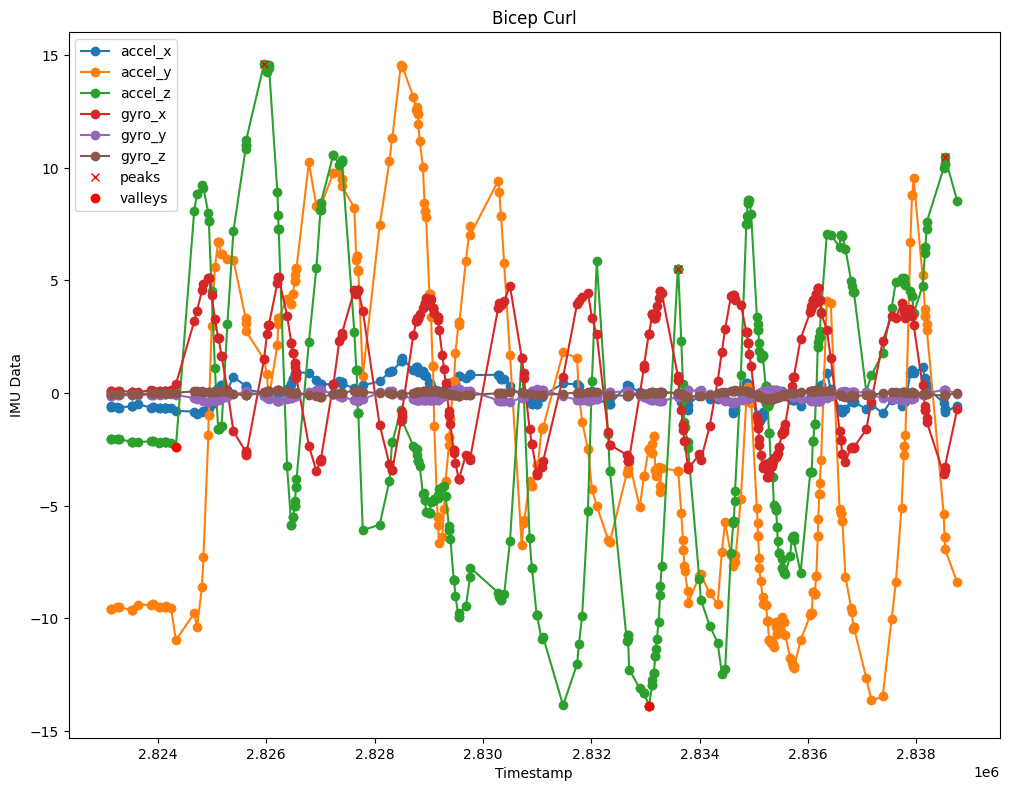

-8.132
valley_outlier_indices: [0 1]
10.192
peak_outlier_indices: []
valid_valley_idxs: []
valid_peak_idxs: [41, 181, 311]
start: 0, end: 313
num_valid_peaks: 3, num_valid_valleys: 0


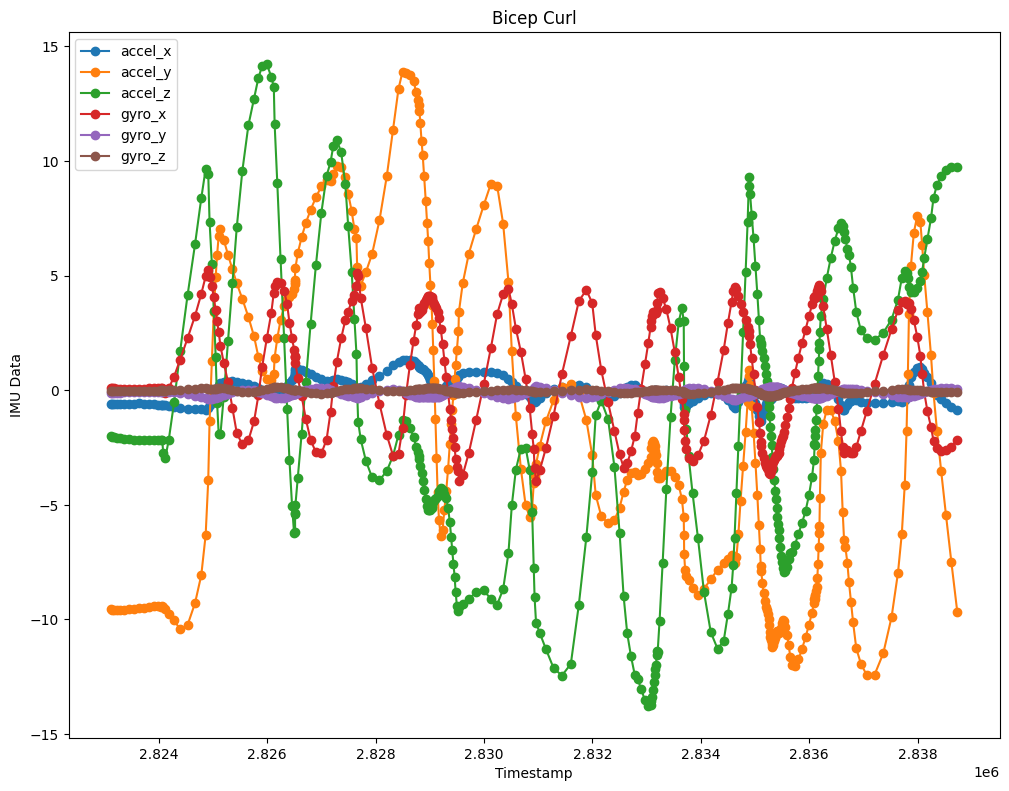

In [3]:
file = "../data2/bicep_curl/bicep_andrew_set3_reps10_1.csv"
df = create_df(file)
peaks, valleys, peakvals, valleyvals = get_peaks_and_valleys(df, 120)
plot_df(df, "Bicep Curl", peaks, valleys)
start, end, num_peaks, num_valleys = get_num_reps(df, peakvals, valleyvals)

df = df.iloc[start:end]
df = smooth_and_resample(df)
plot_df(df, "Bicep Curl")

../data2/bicep_curl/bicep_adam_set1_reps10_1.csv


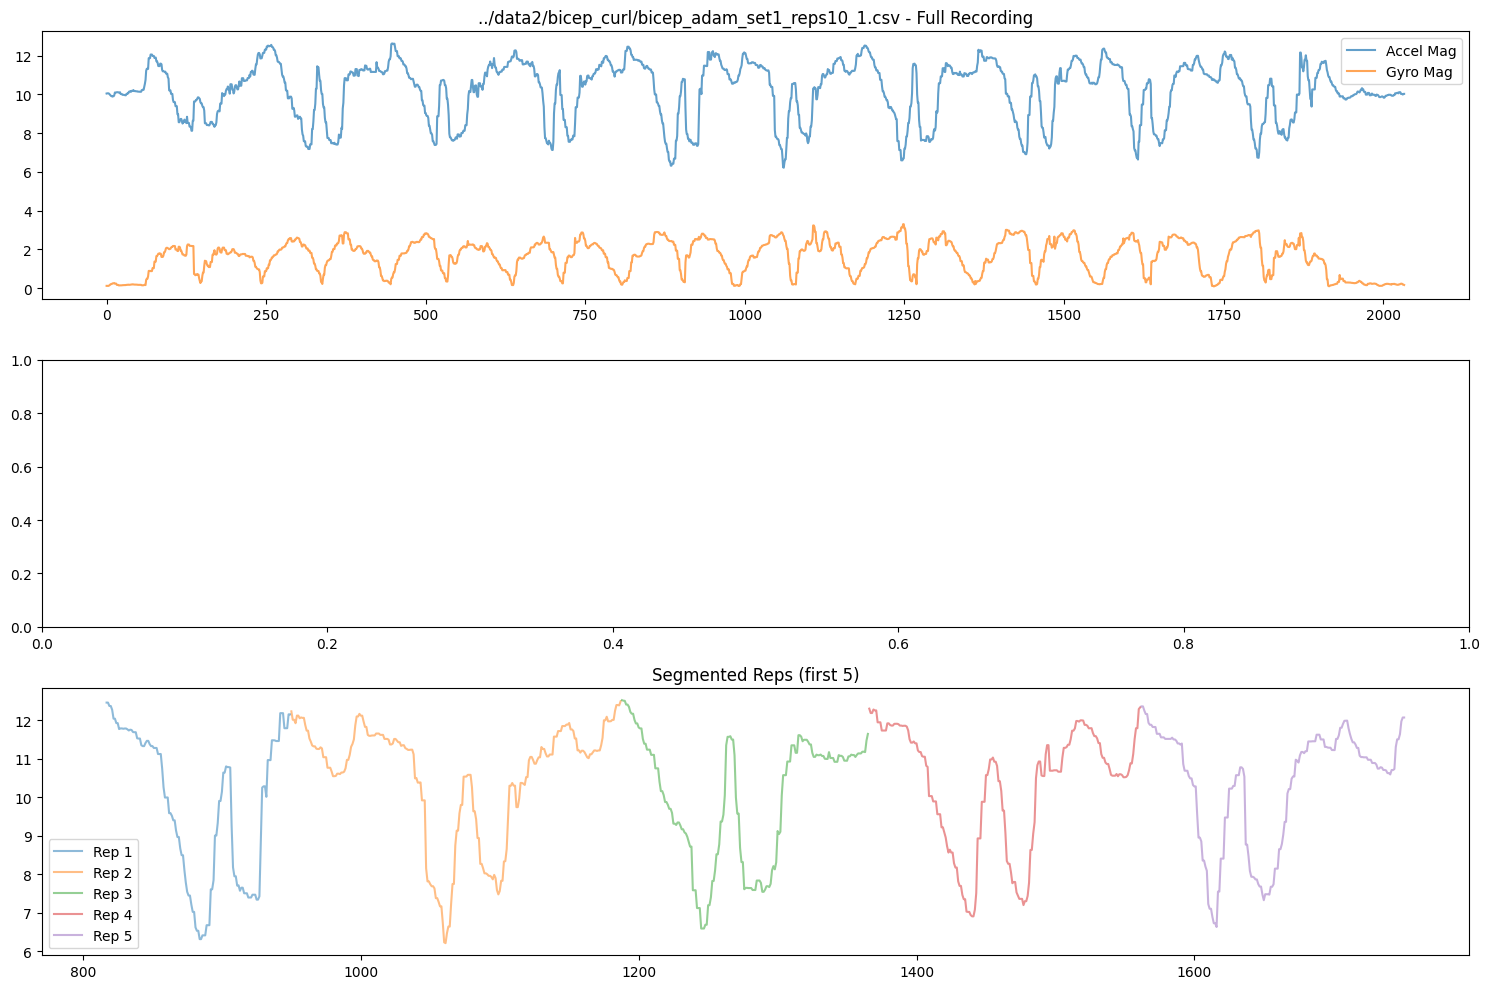

../data2/bicep_curl/bicep_andrew_set2_reps10_1.csv


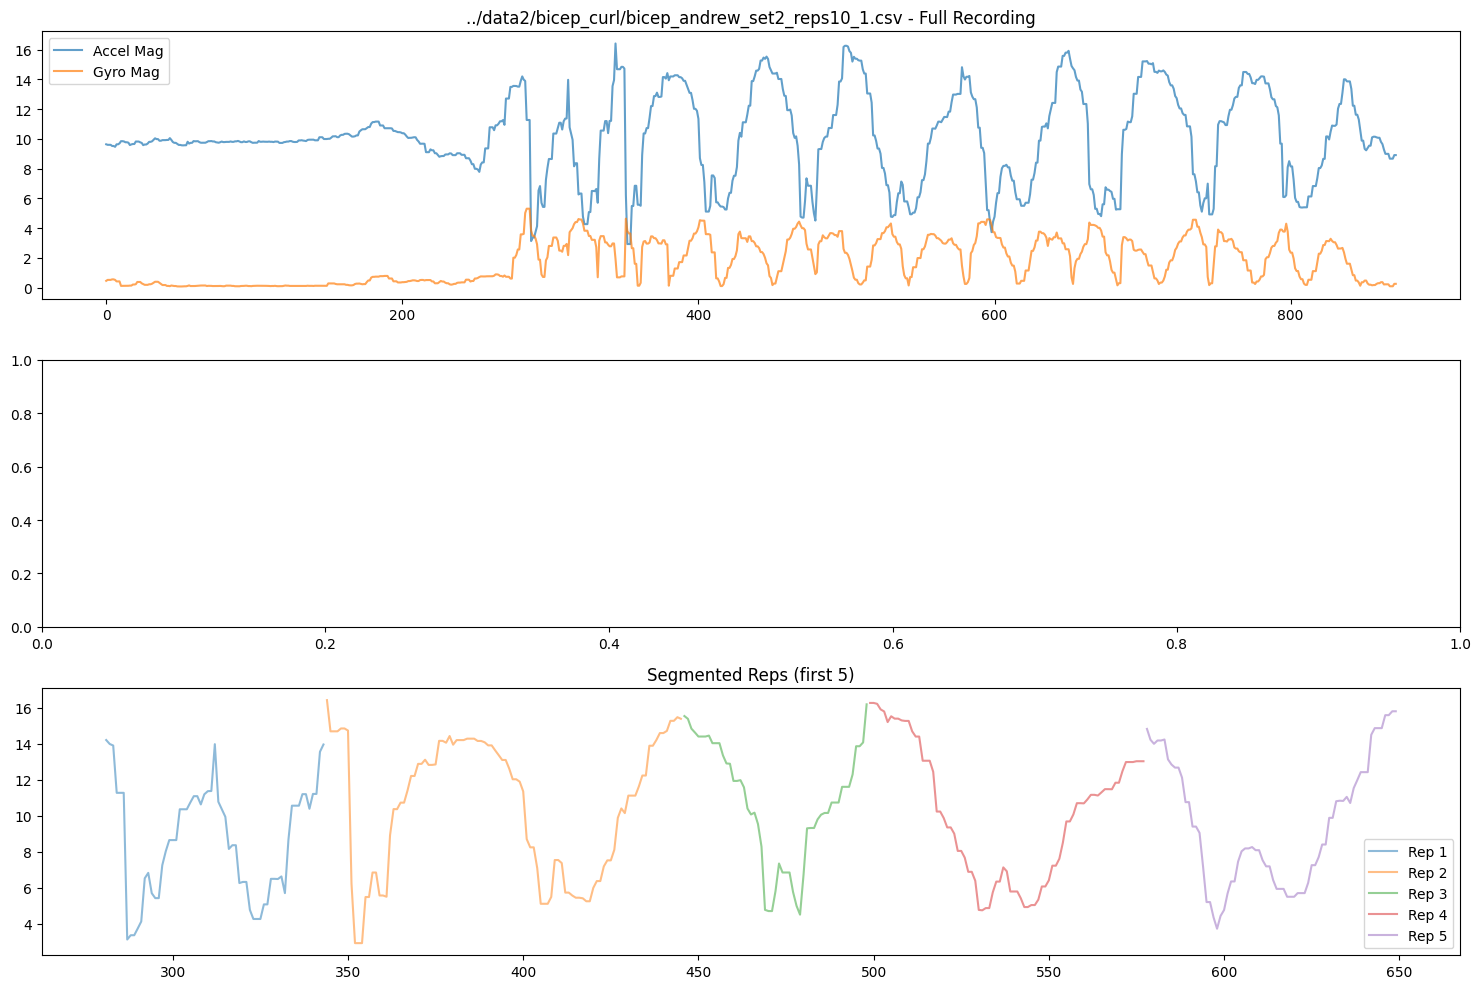

../data2/bicep_curl/bicep_anuj_set1_rep10_1.csv


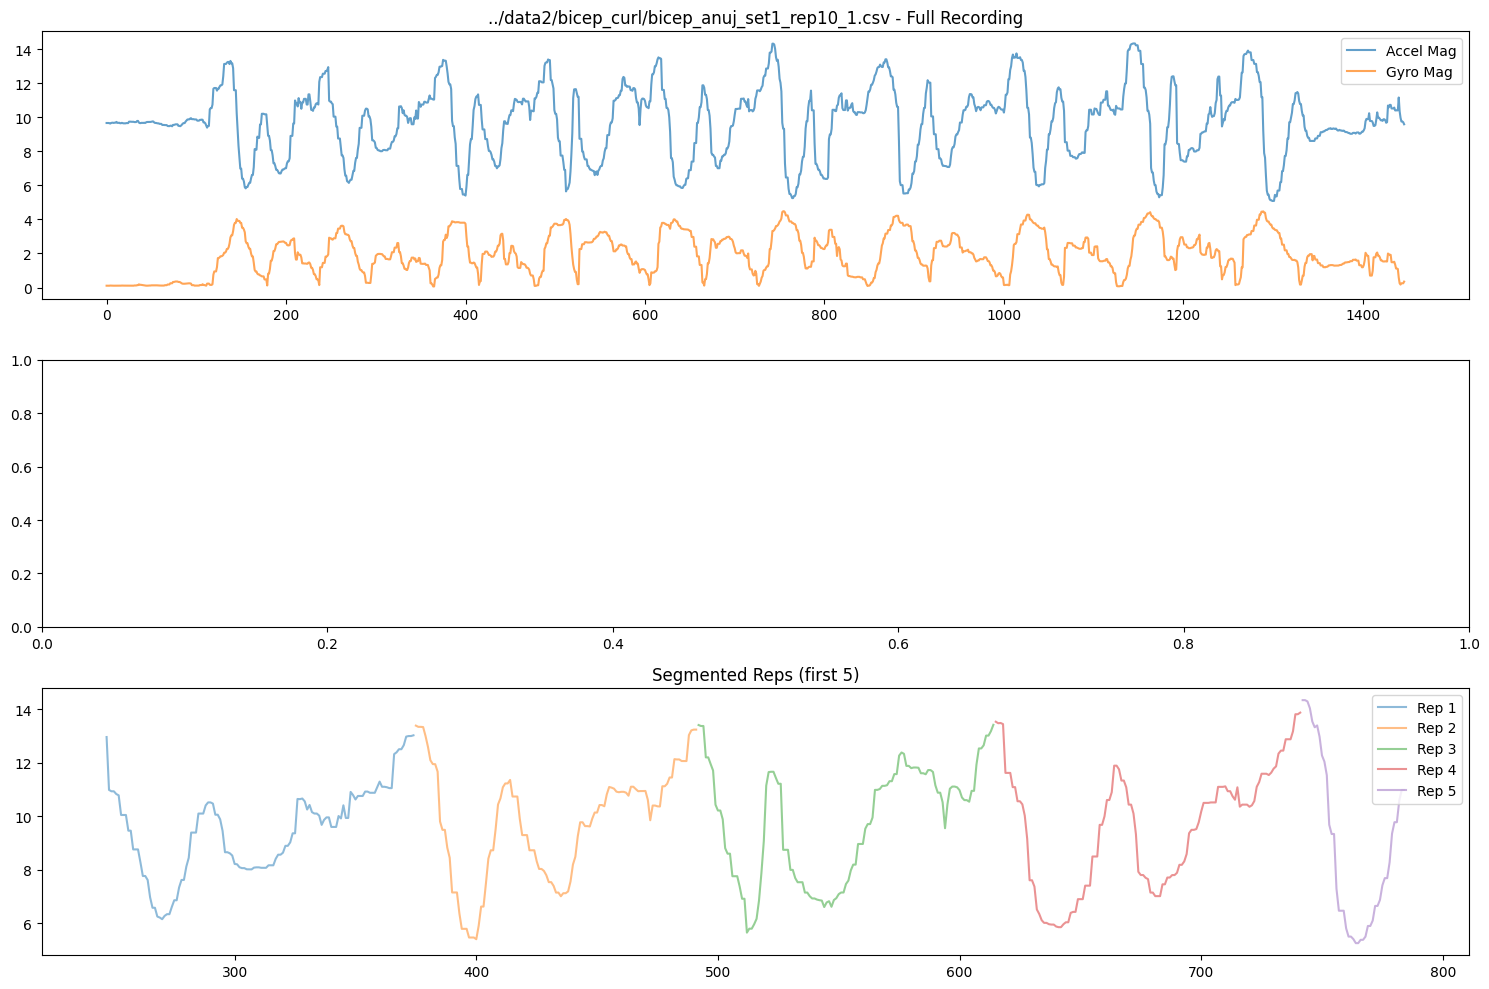

../data2/bicep_curl/bicep_jake_set1_reps10_1.csv


/var/folders/9x/nppf0cj96gl0gcz3tcx7txmm0000gn/T/ipykernel_32087/4264898585.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend()


../data2/bicep_curl/bicep_kamyar_set1_reps10_1.csv


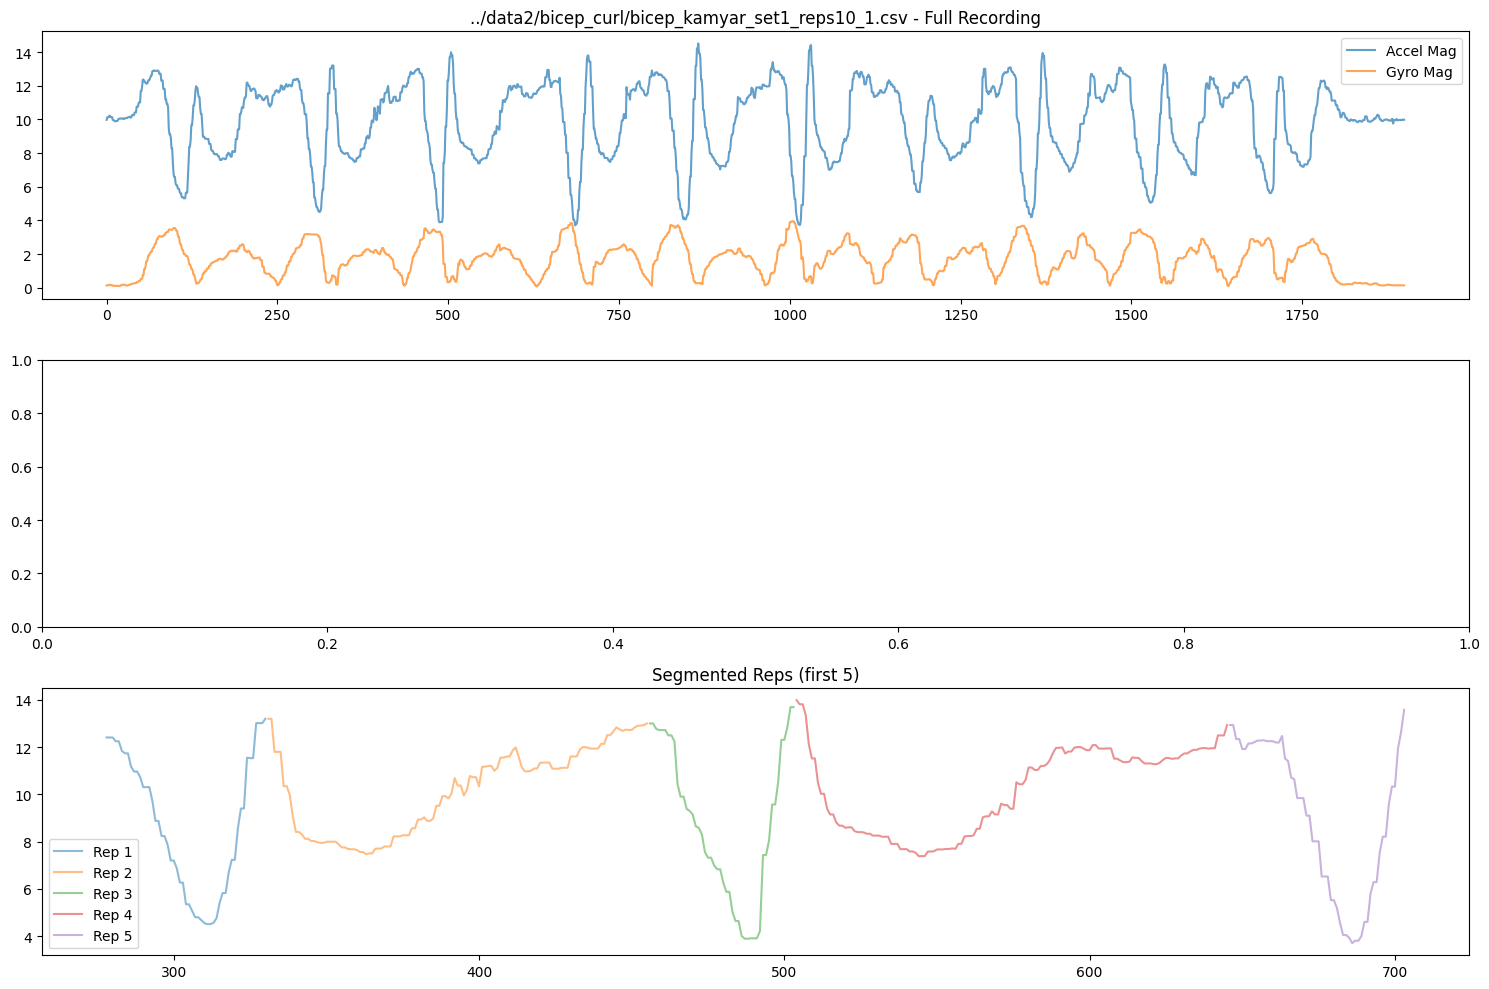

../data2/bicep_curl/bicep_mike_set1_reps10_1.csv


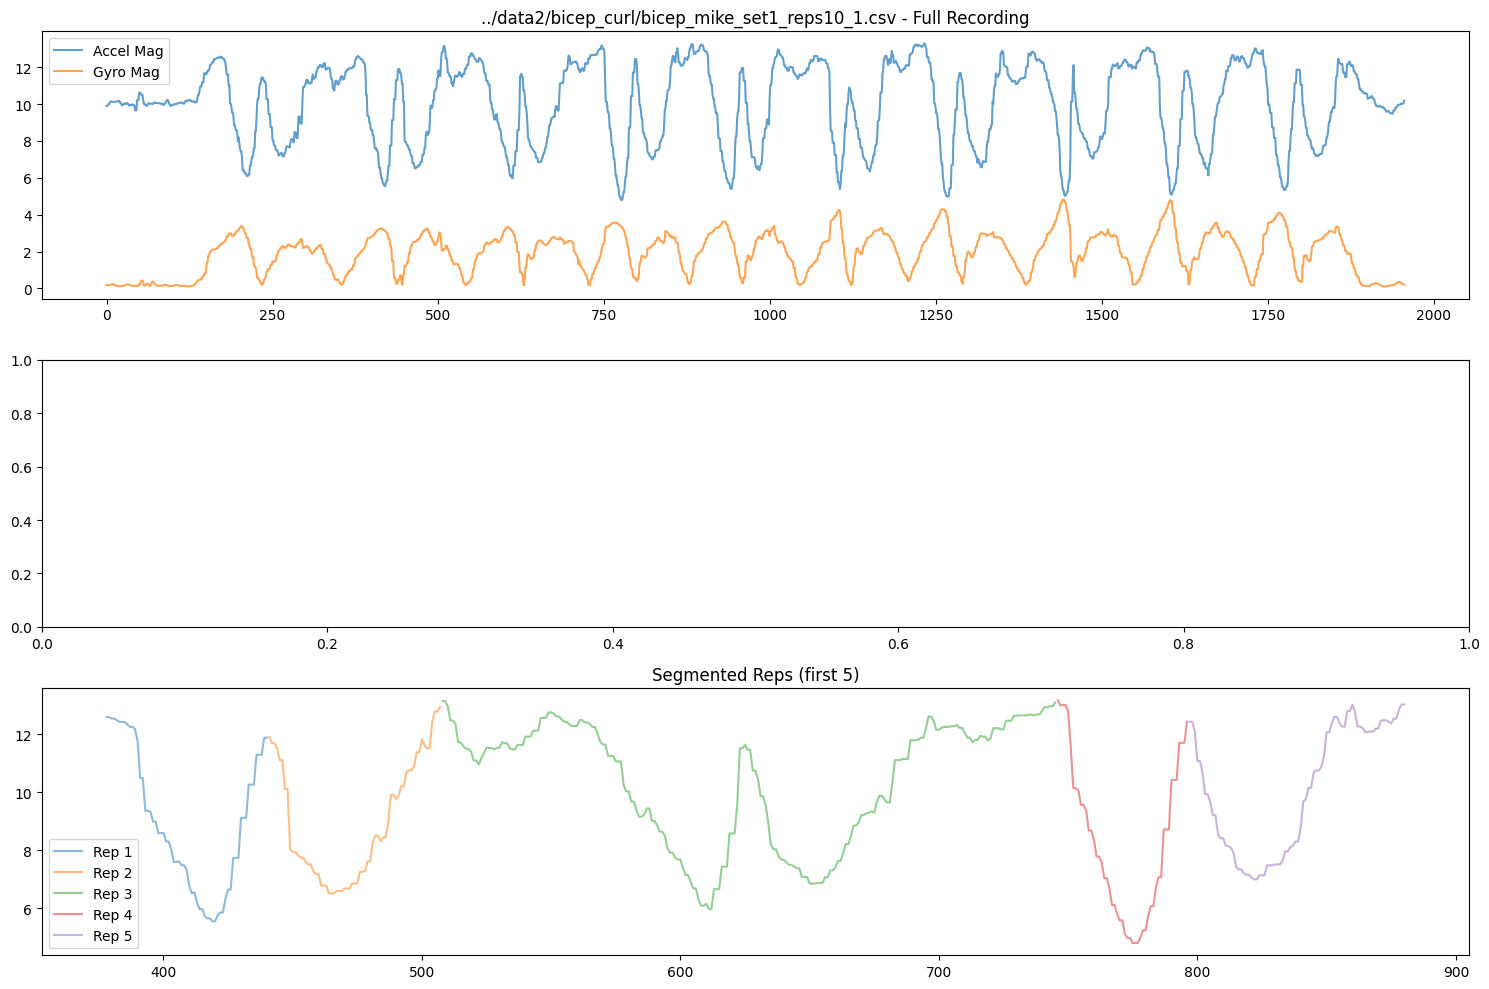

../data2/bicep_curl/bicep_suzan_set1_reps10_1.csv


/var/folders/9x/nppf0cj96gl0gcz3tcx7txmm0000gn/T/ipykernel_32087/4264898585.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend()


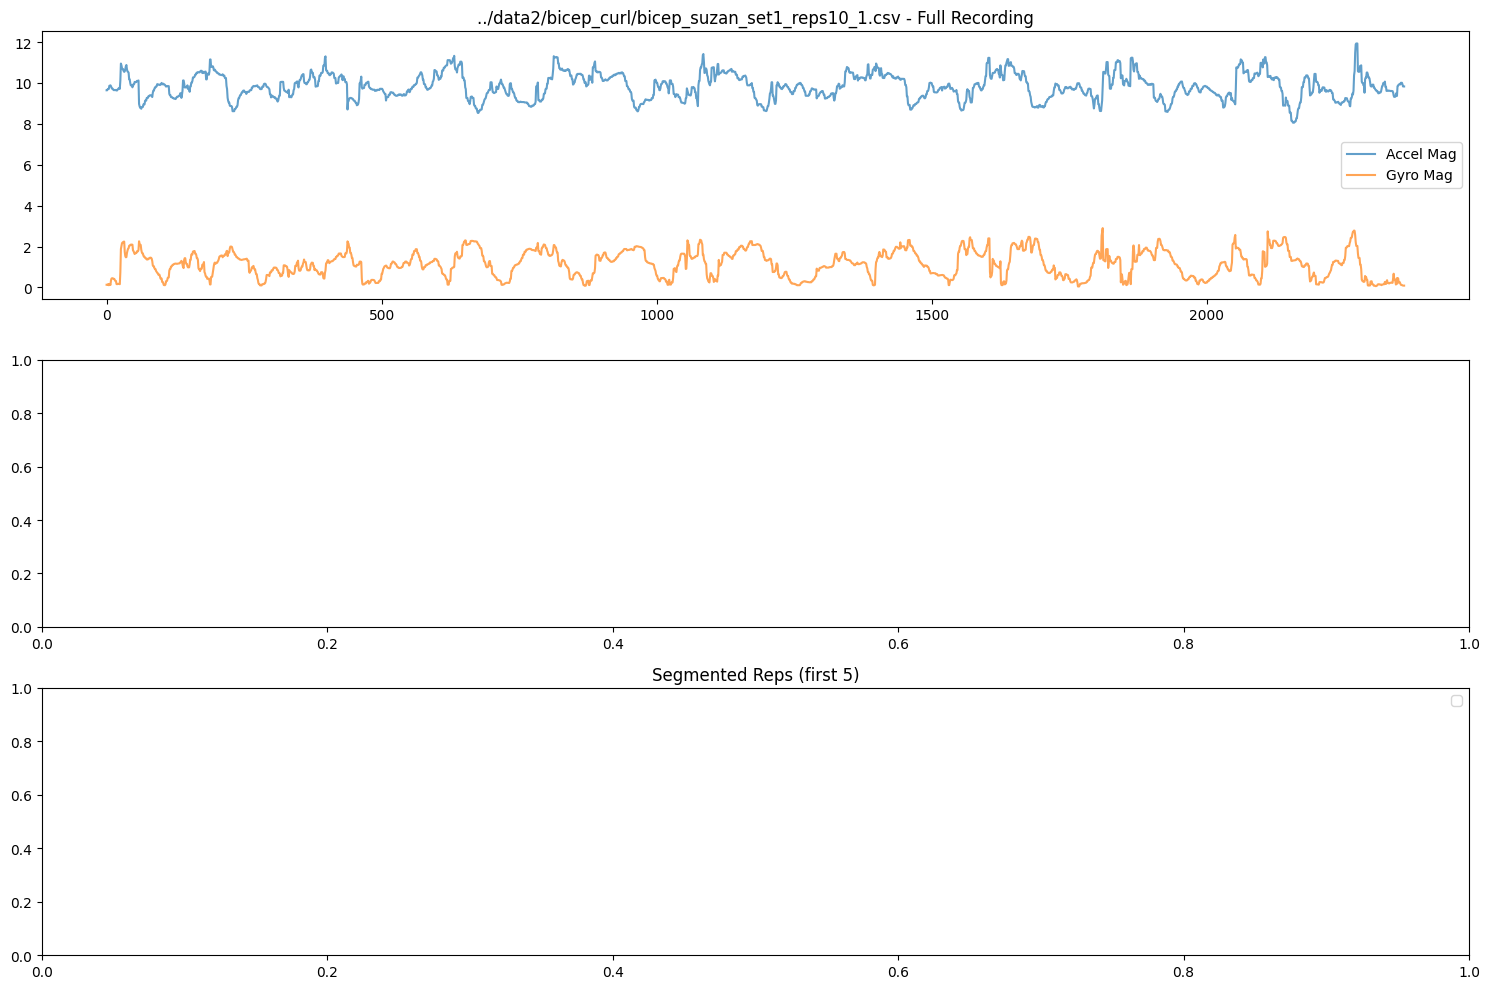

../data2/bicep_curl/bicep_udai_set1_reps10_1.csv


/var/folders/9x/nppf0cj96gl0gcz3tcx7txmm0000gn/T/ipykernel_32087/4264898585.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend()


../data2/shoulder_press/shoulder_adam_set1_reps10_1.csv


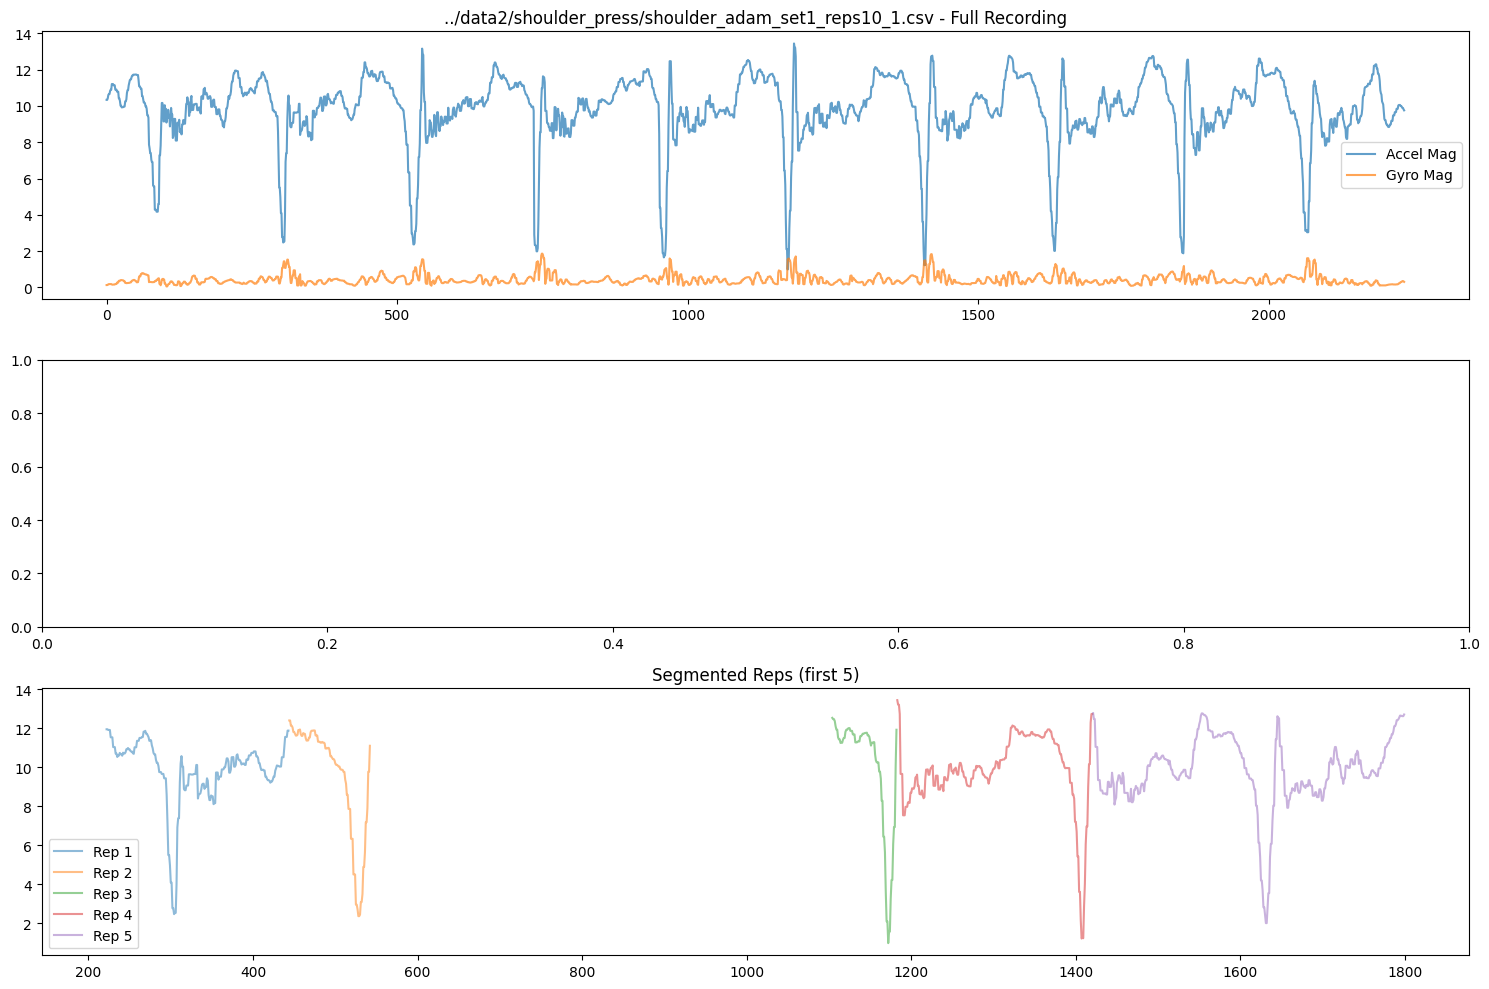

../data2/shoulder_press/shoulder_andrew_set1_reps10_1.csv


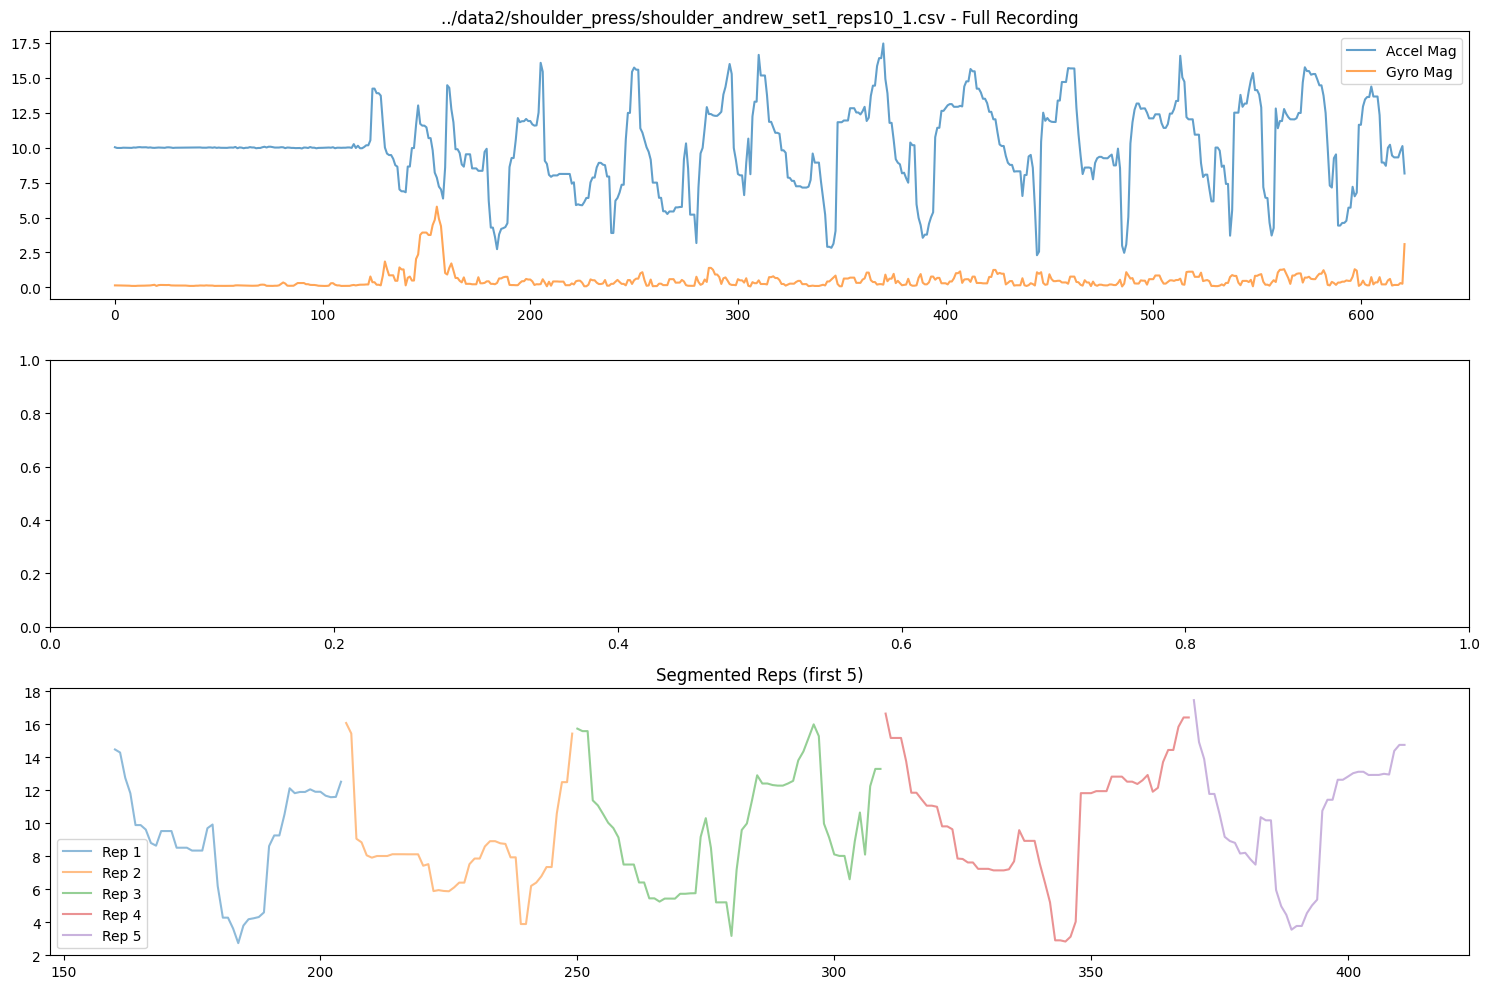

../data2/shoulder_press/shoulder_anuj_set1_rep10_1.csv


../data2/shoulder_press/shoulder_kamyar_set1_reps10_1.csv


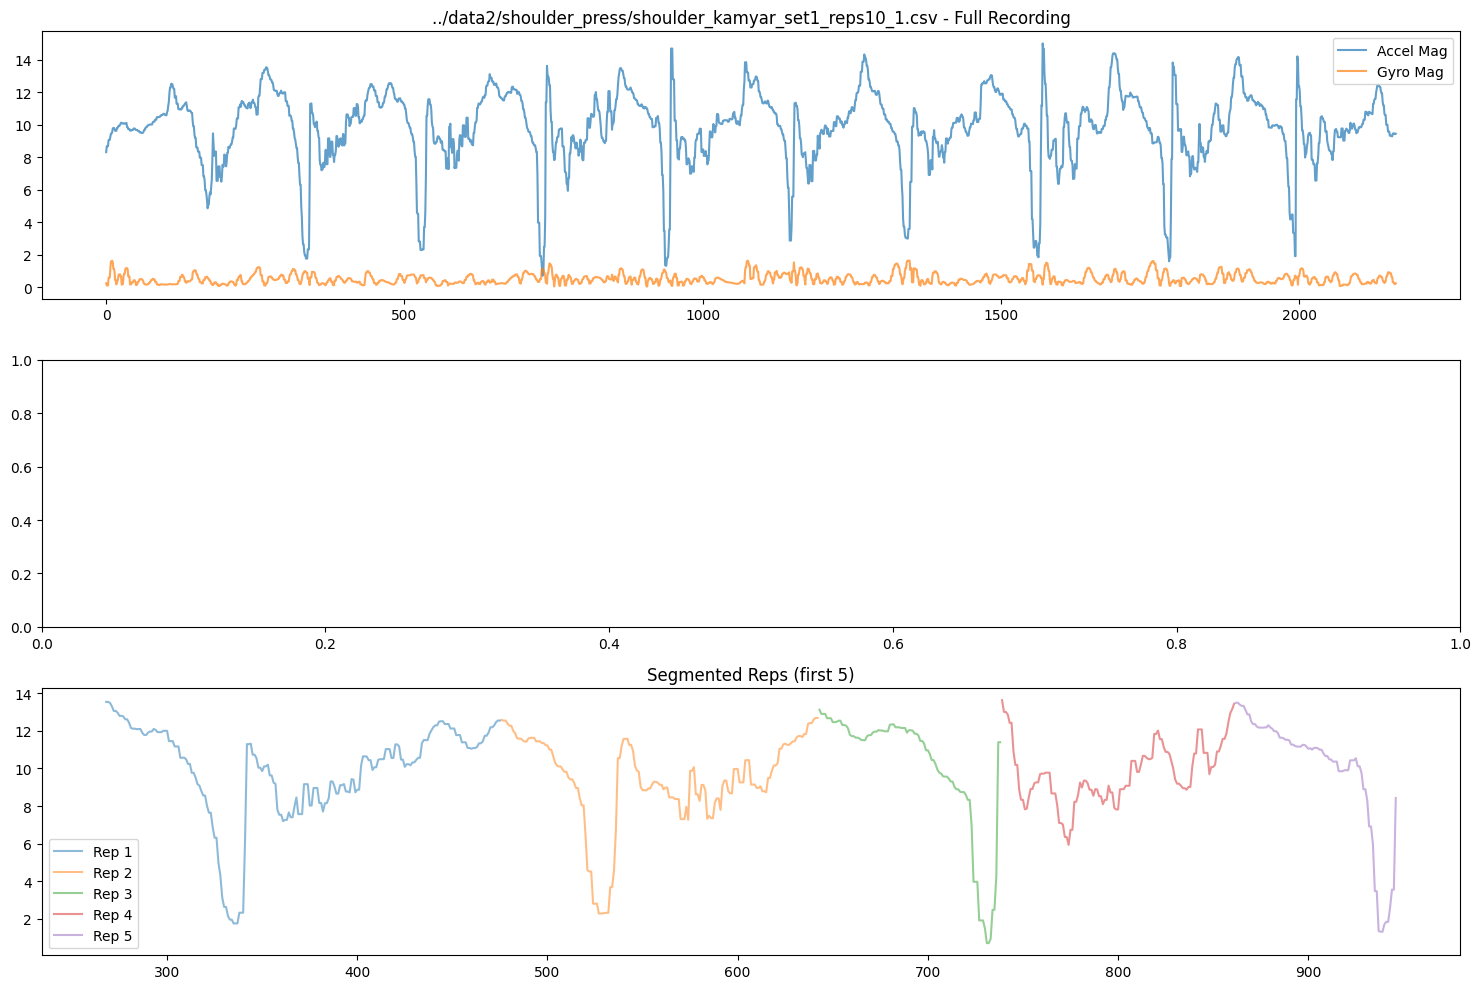

../data2/shoulder_press/shoulder_mike_set1_reps10_1.csv


../data2/shoulder_press/shoulder_suzan_set1_reps10_1.csv


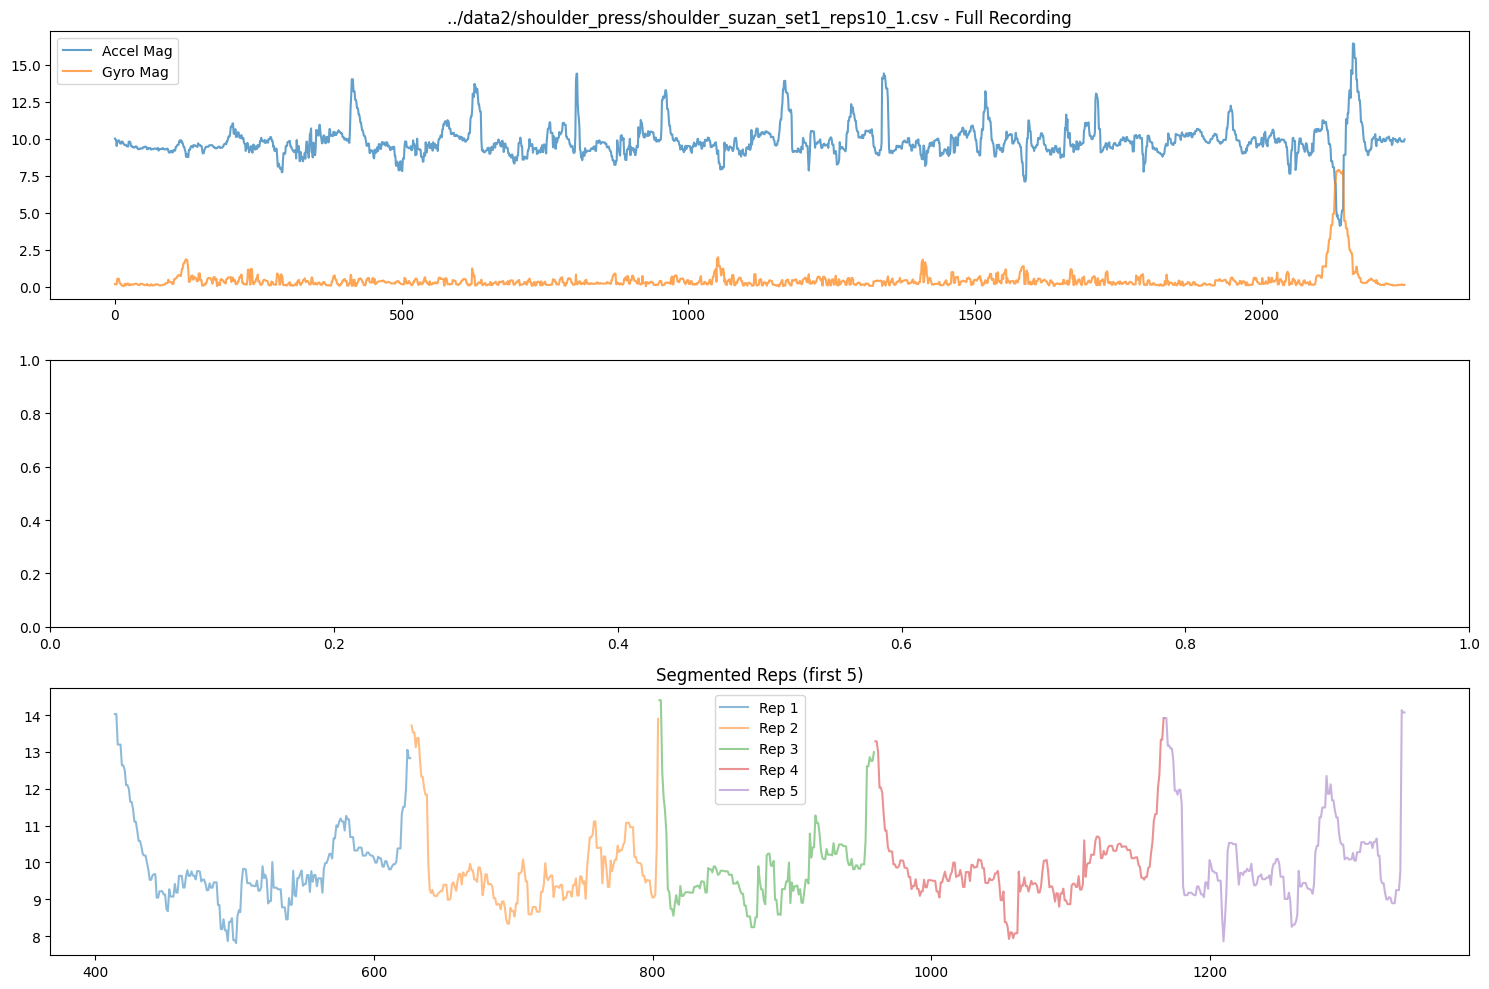

../data2/shoulder_press/shoulder_udai_set1_reps10_1.csv


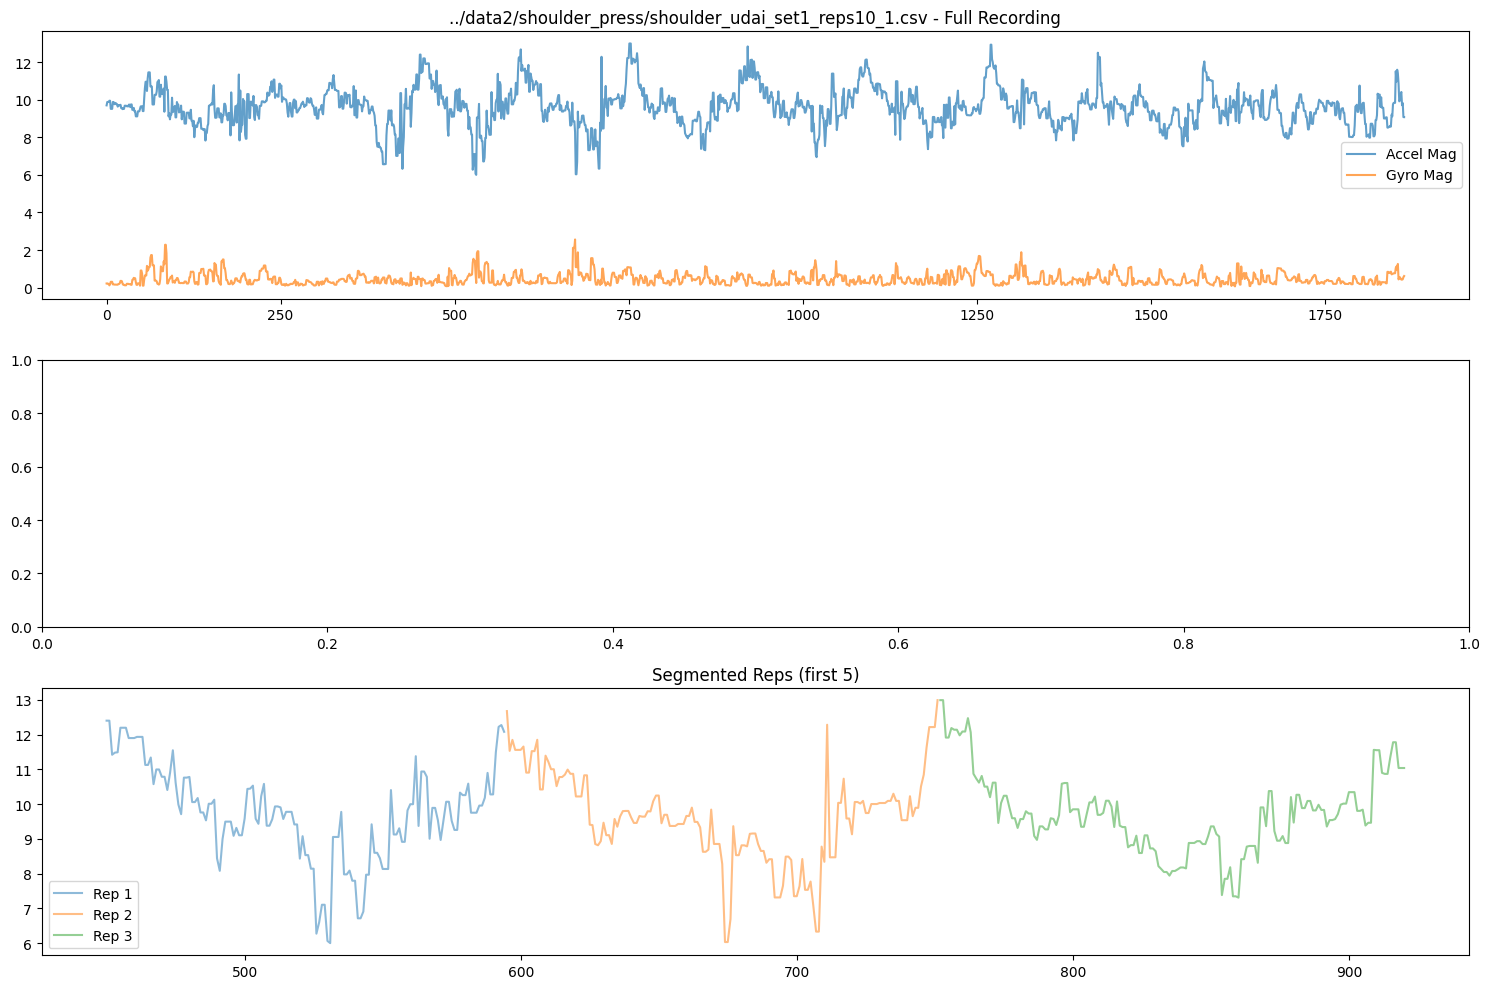

../data2/shoulder_press/shoulder_suzan_set3_reps10_1.csv


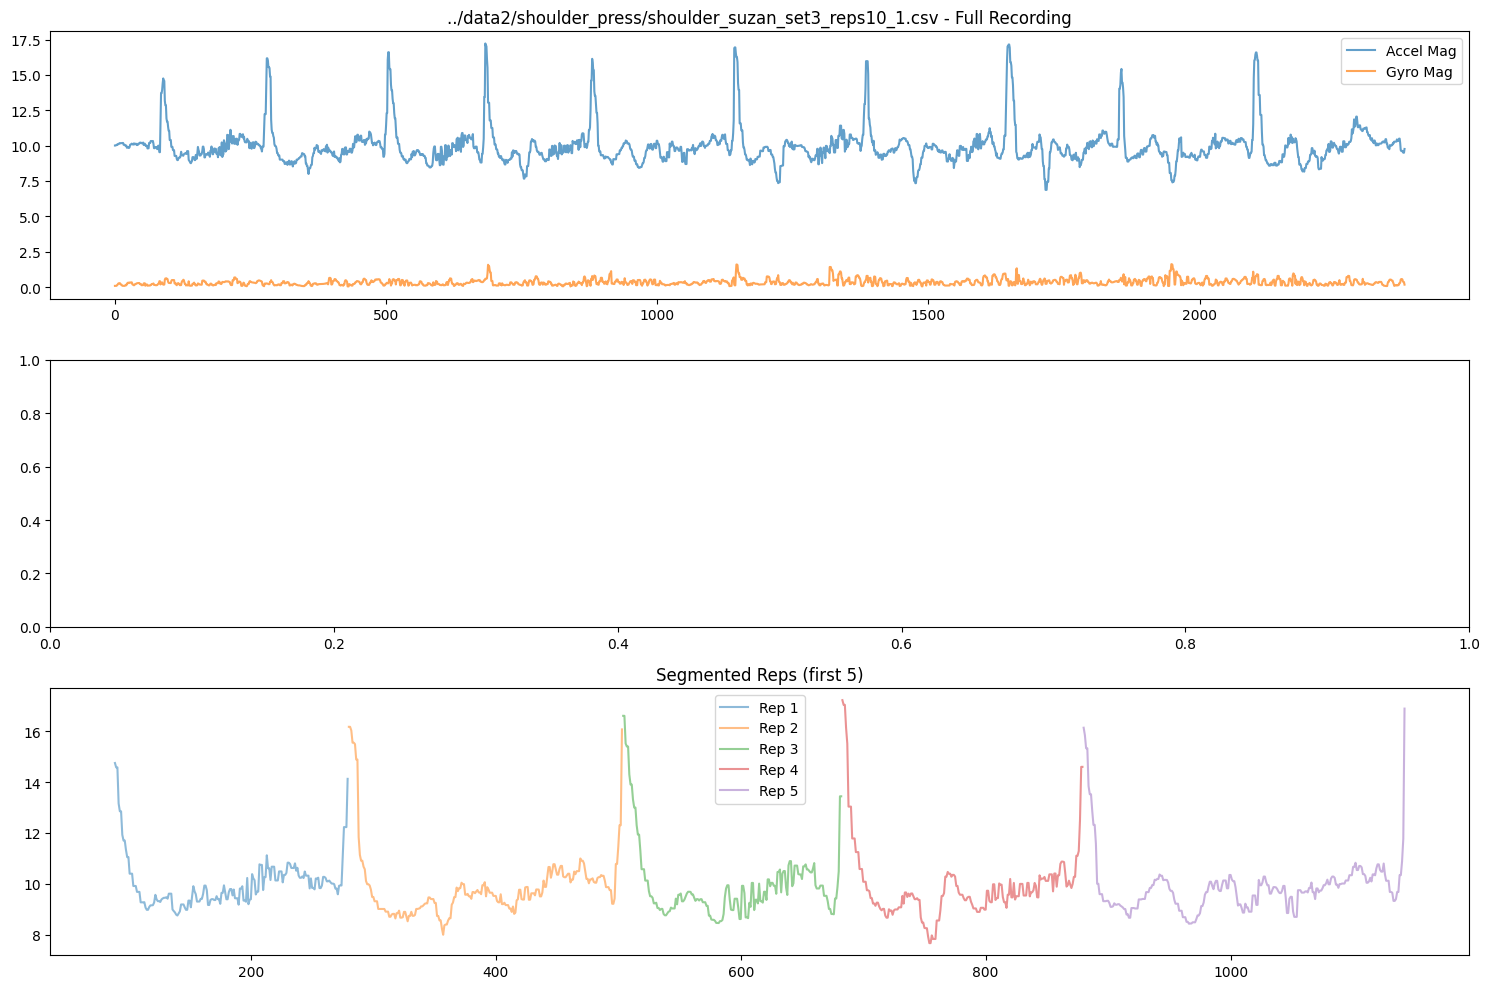

../data2/row/row_adam_set1_reps10_1.csv


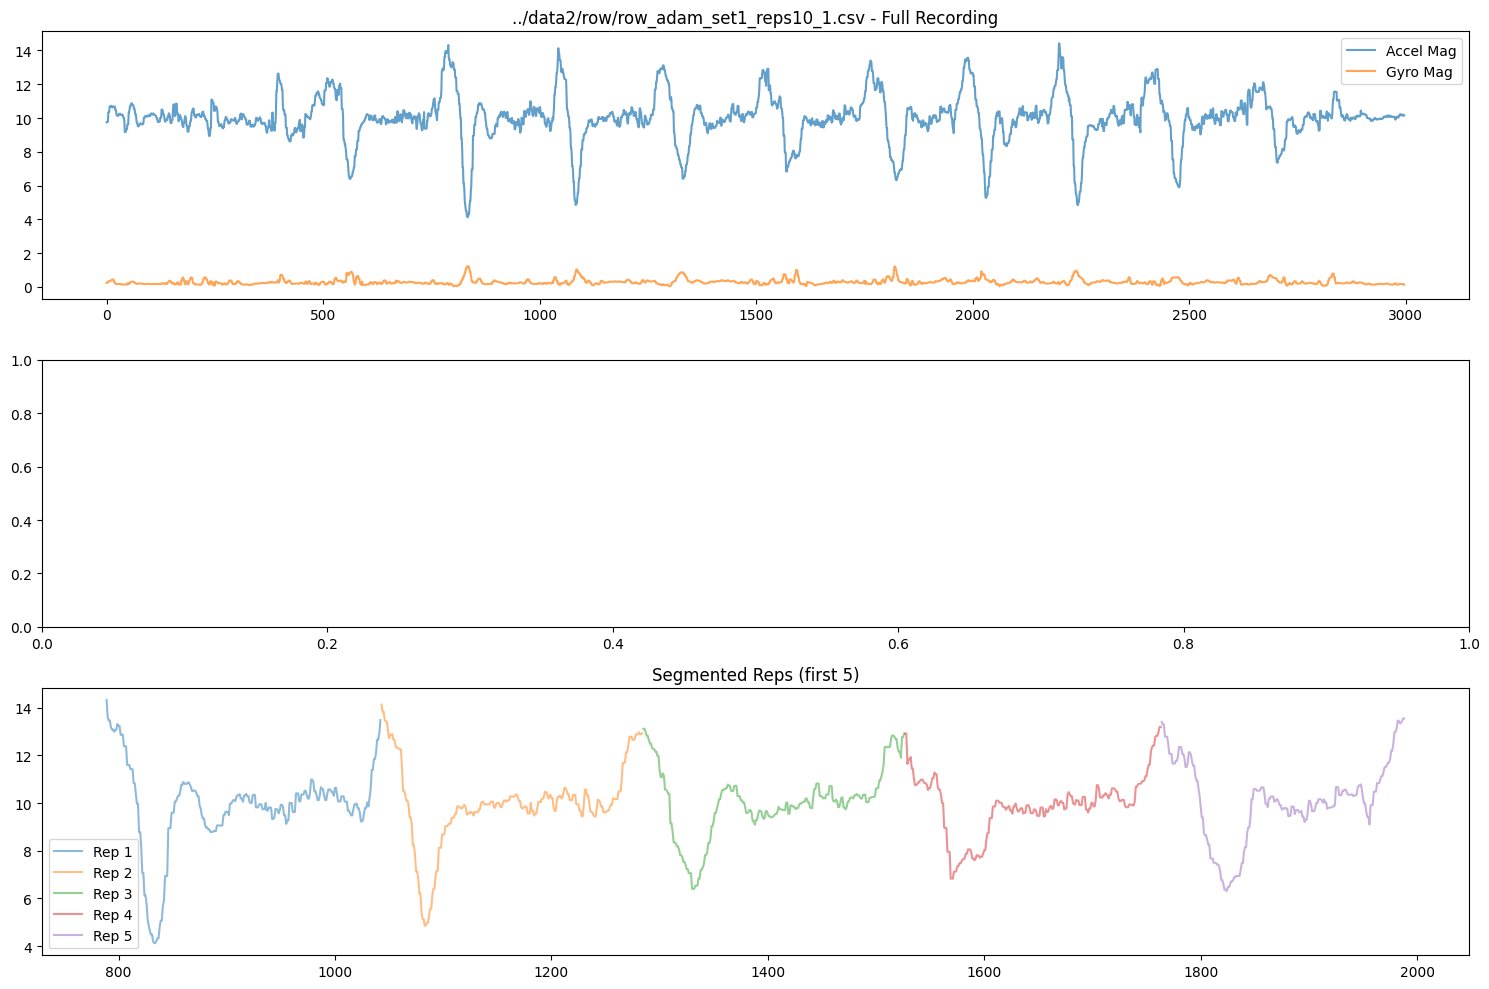

../data2/row/row_andrew_set1_reps10_1.csv


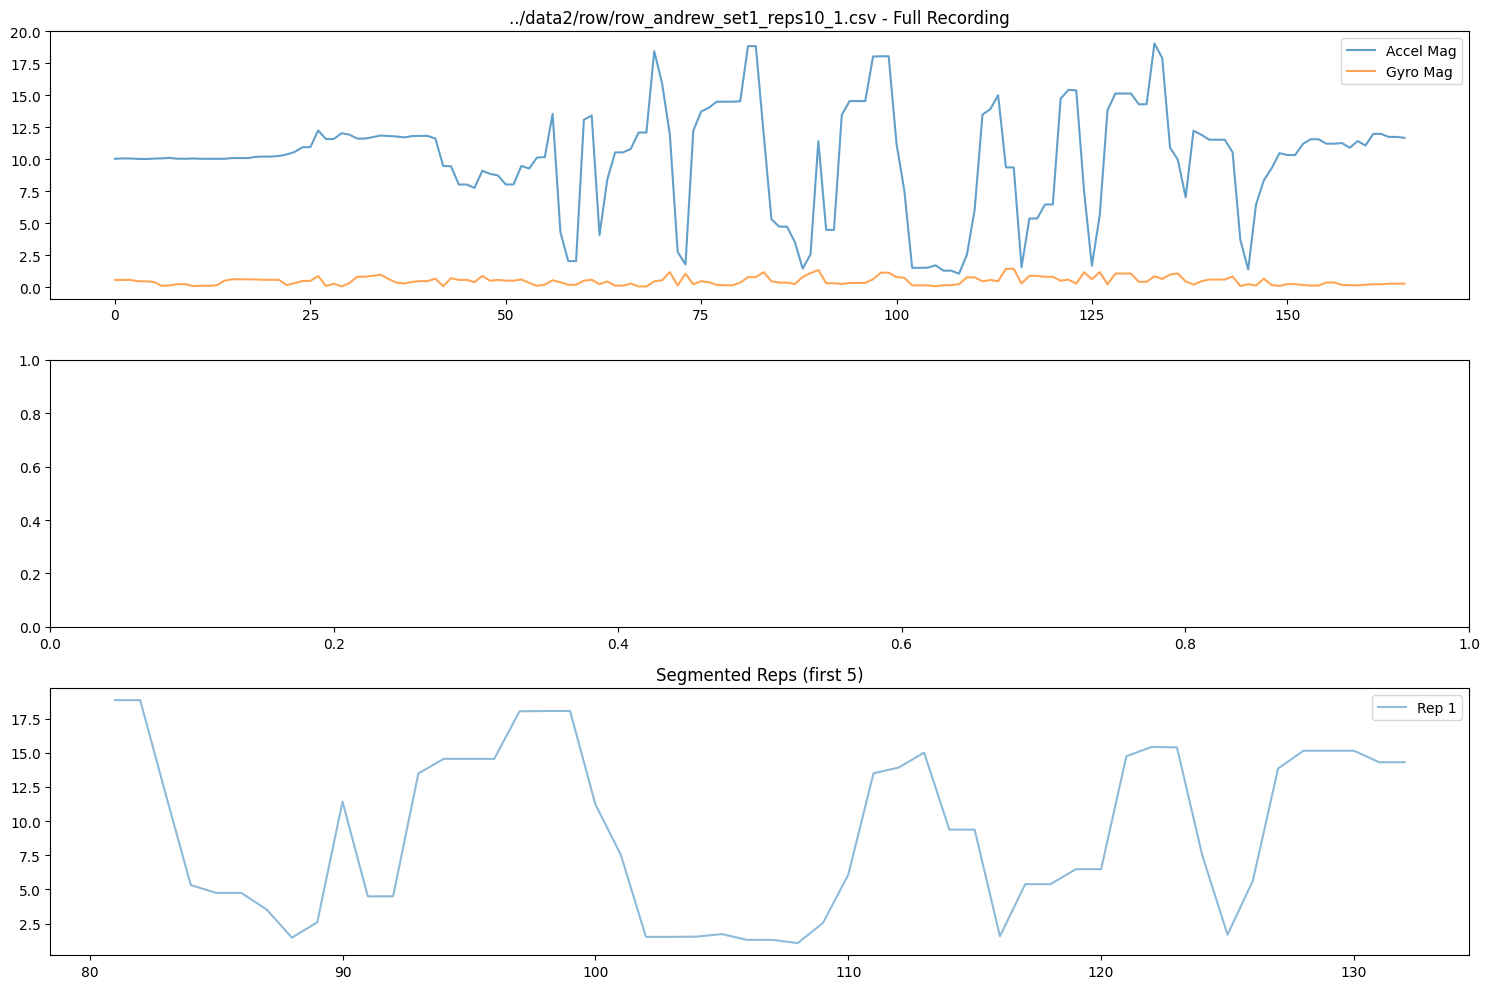

../data2/row/row_anuj_set1_rep10_1.csv


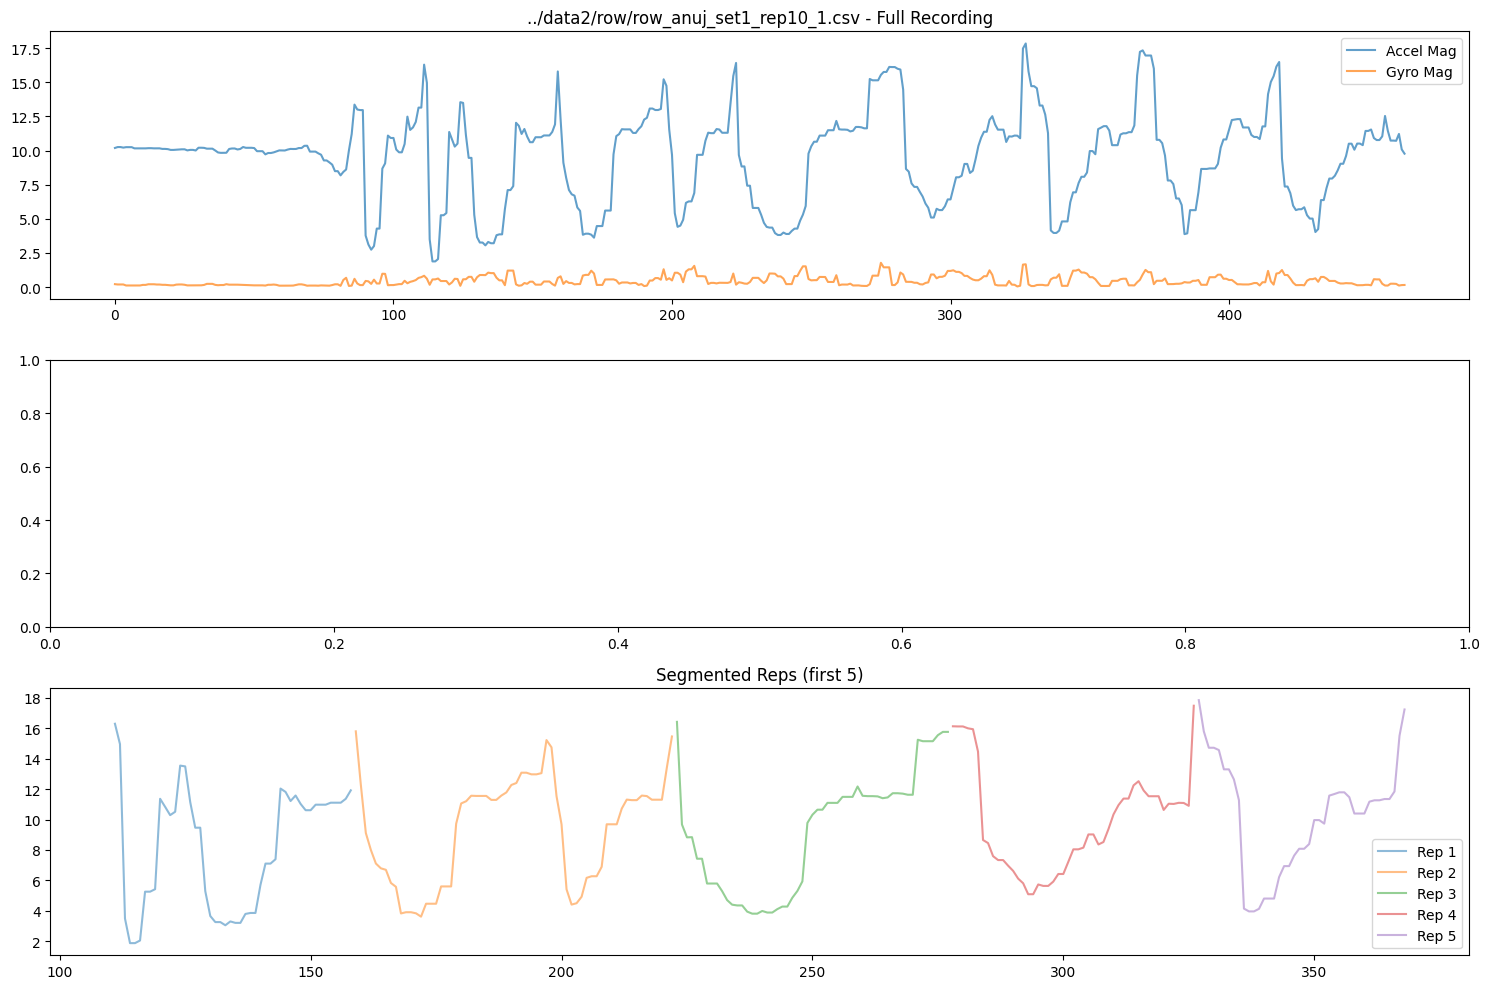

../data2/row/row_jake_set1_reps12_1.csv


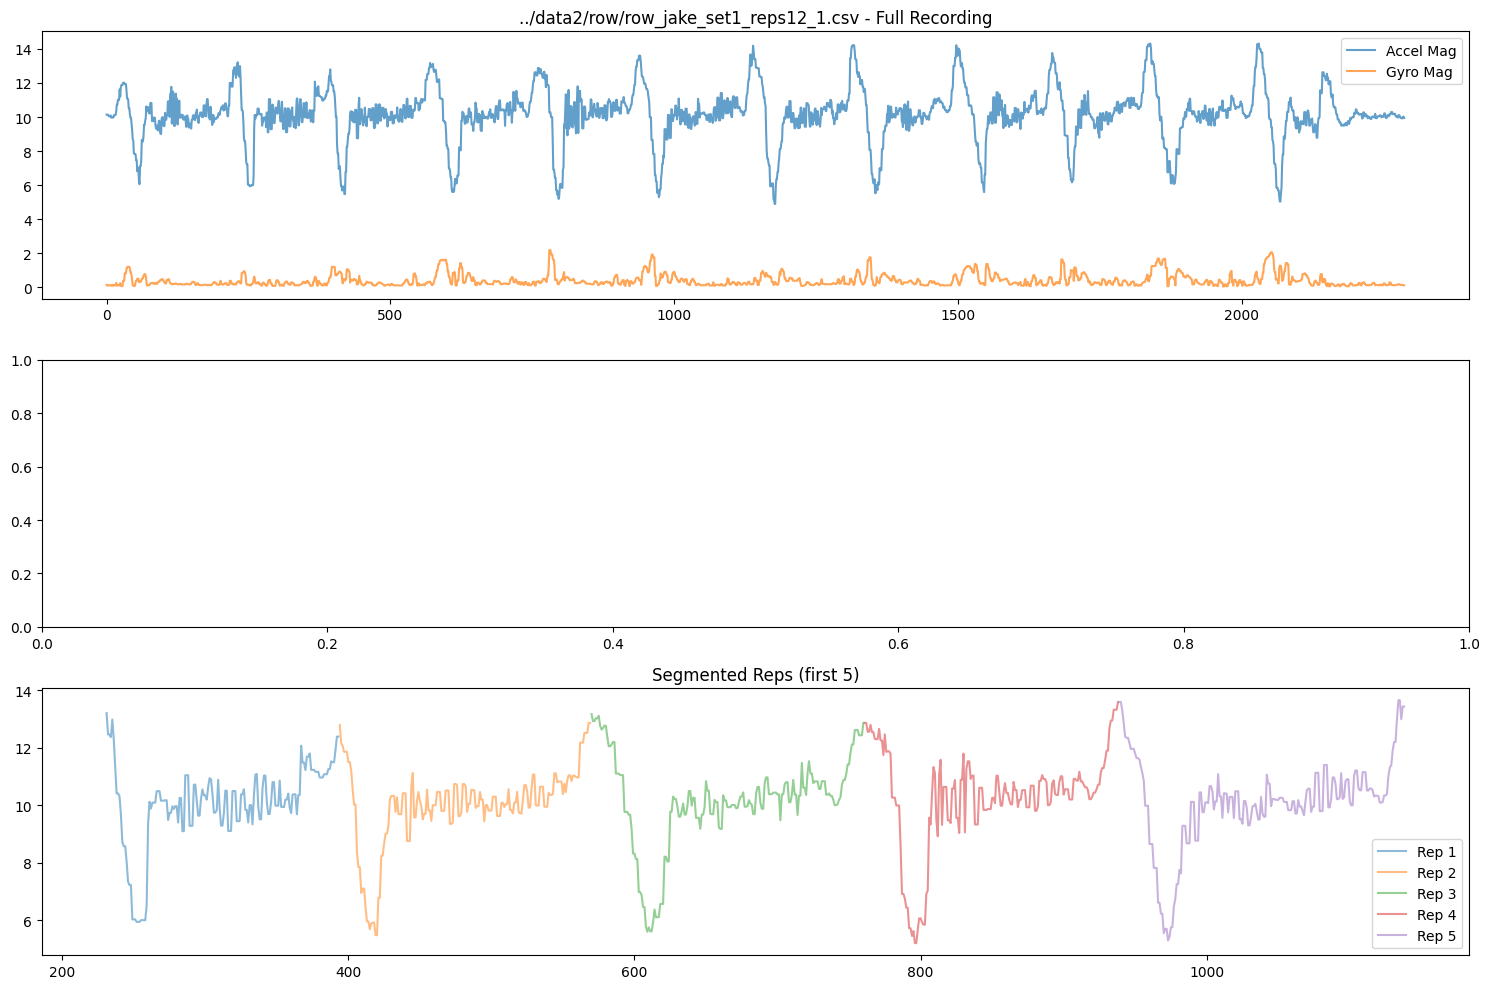

../data2/row/row_kamyar_set1_reps10_1.csv


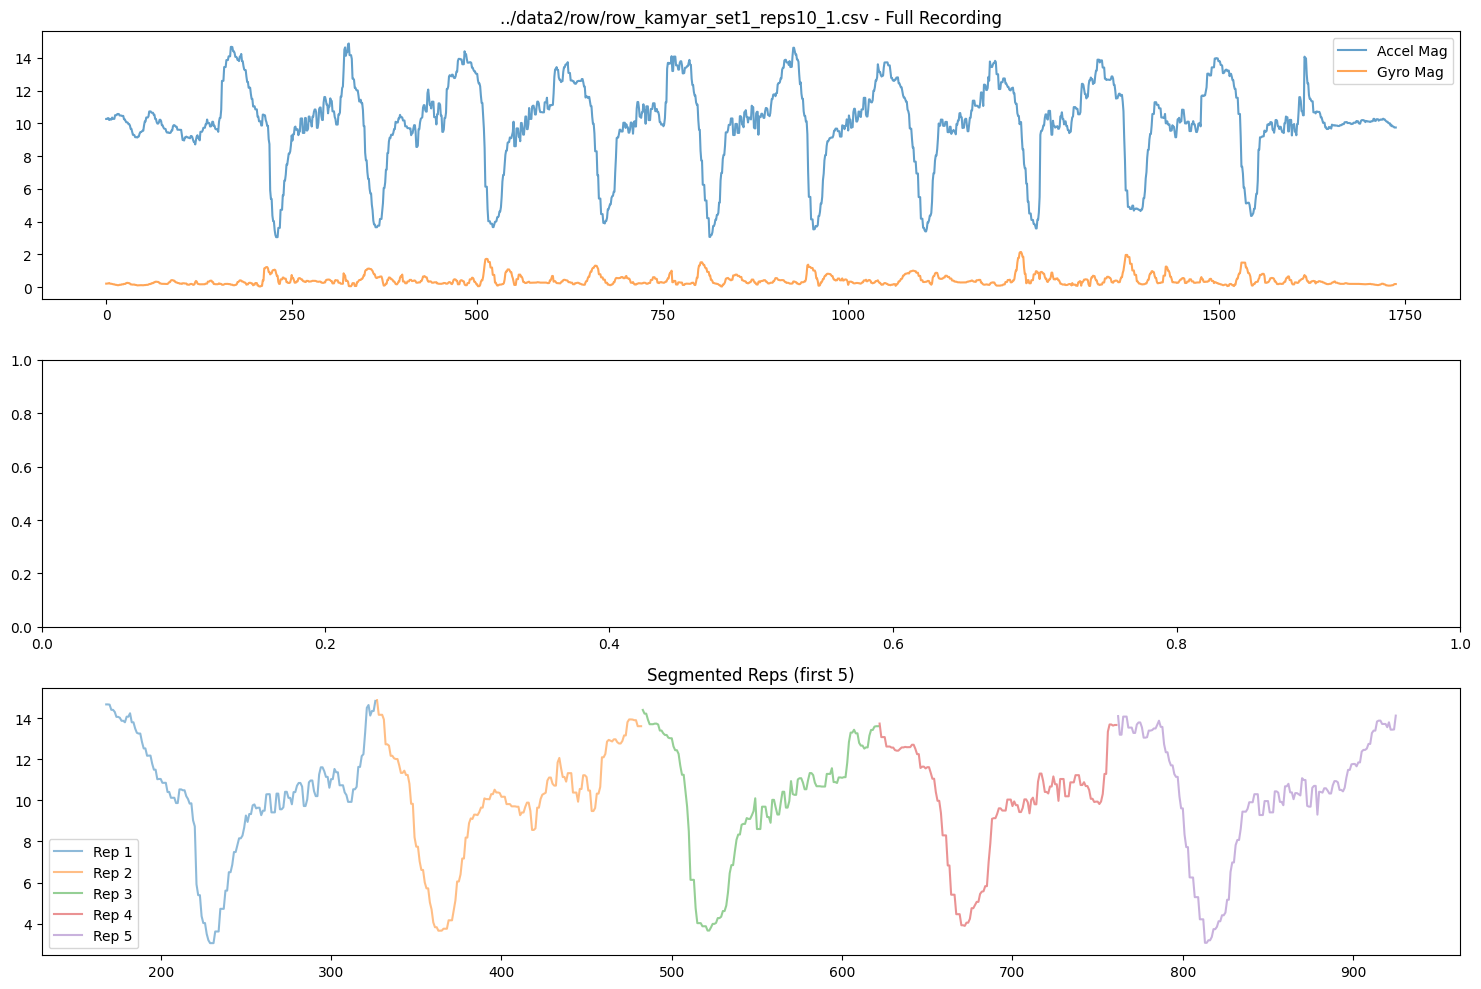

../data2/row/row_mike_set1_reps10_1.csv


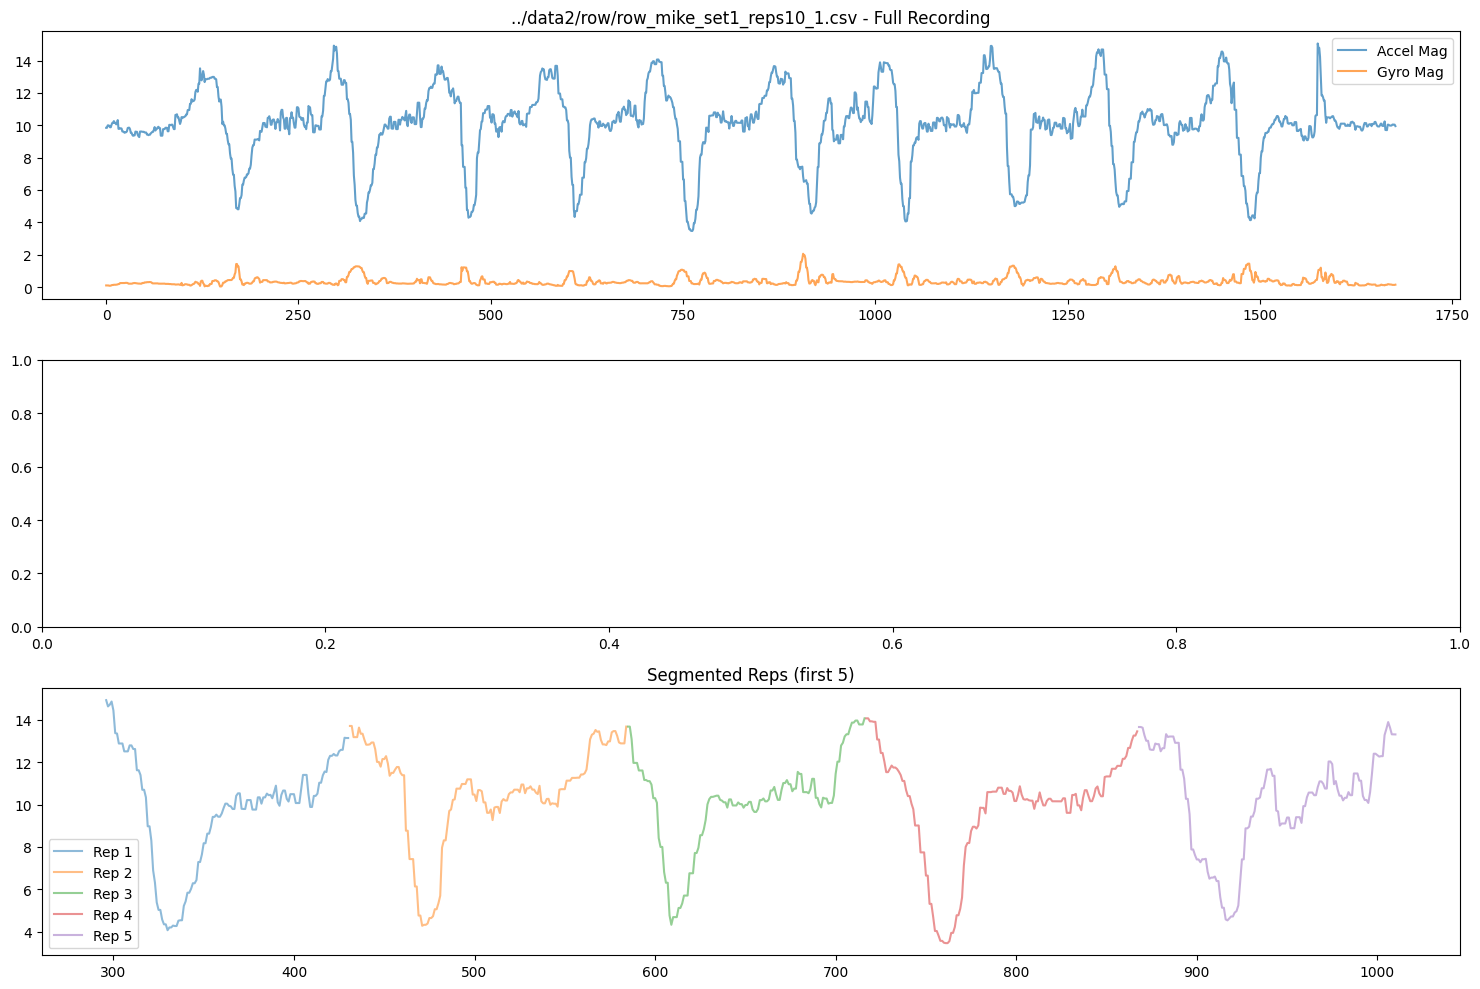

../data2/row/row_suzan_set1_reps10_1.csv


../data2/row/row_udai_set1_reps12_1.csv


../data2/dead/dead_adam_set1_reps10_1.csv


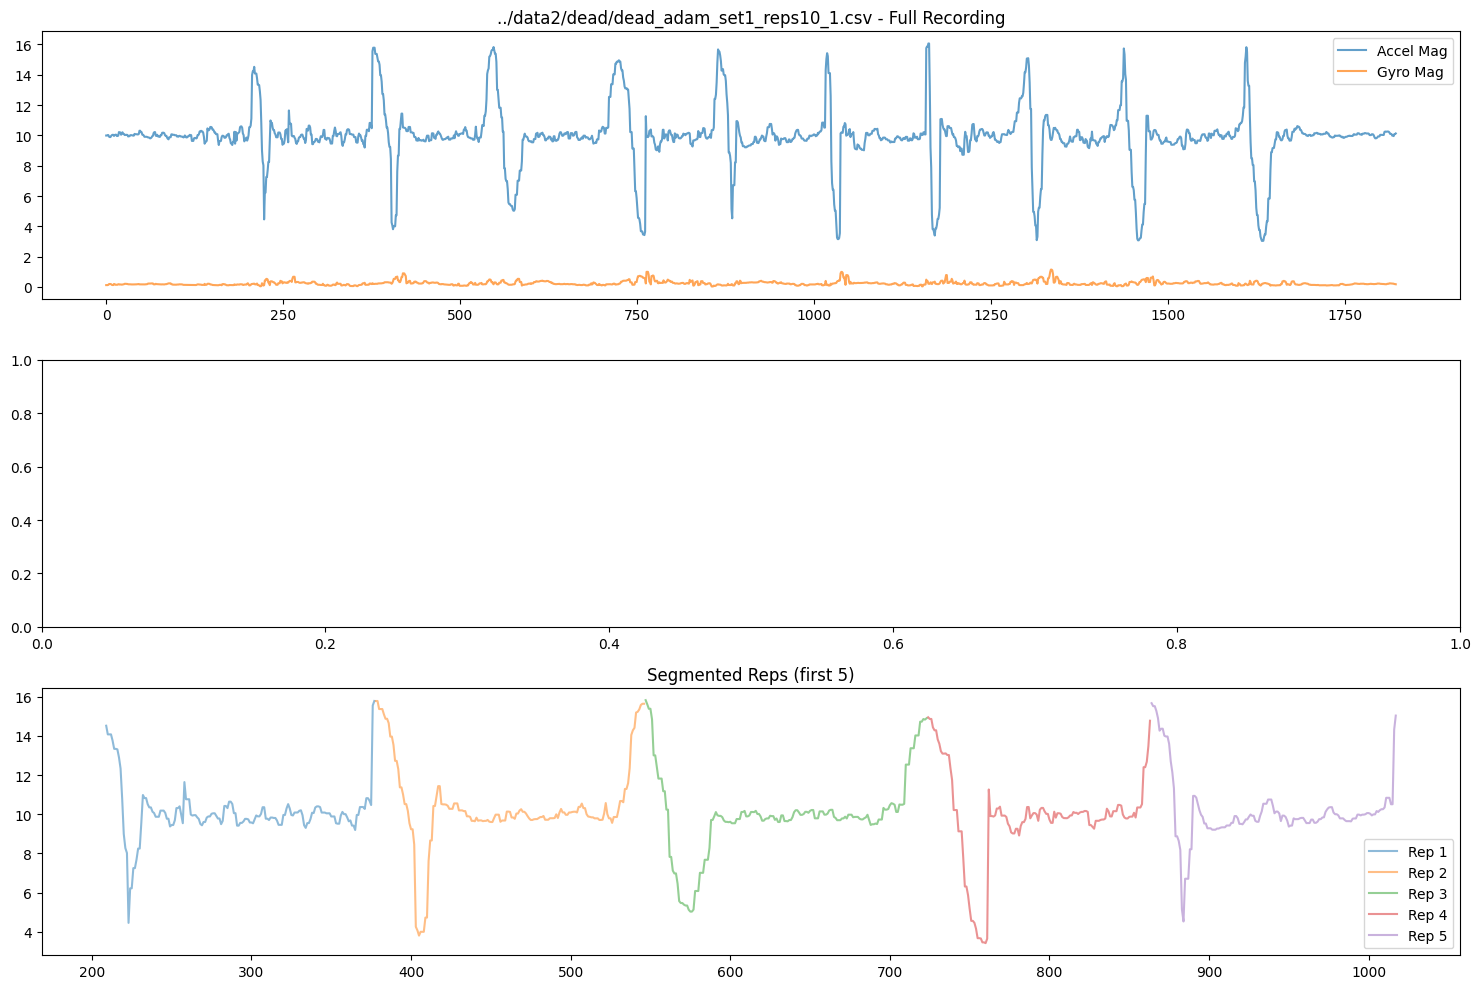

../data2/dead/dead_andrew_set1_reps10_1.csv


/var/folders/9x/nppf0cj96gl0gcz3tcx7txmm0000gn/T/ipykernel_32087/4264898585.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend()


../data2/dead/dead_anuj_set1_rep10_1.csv


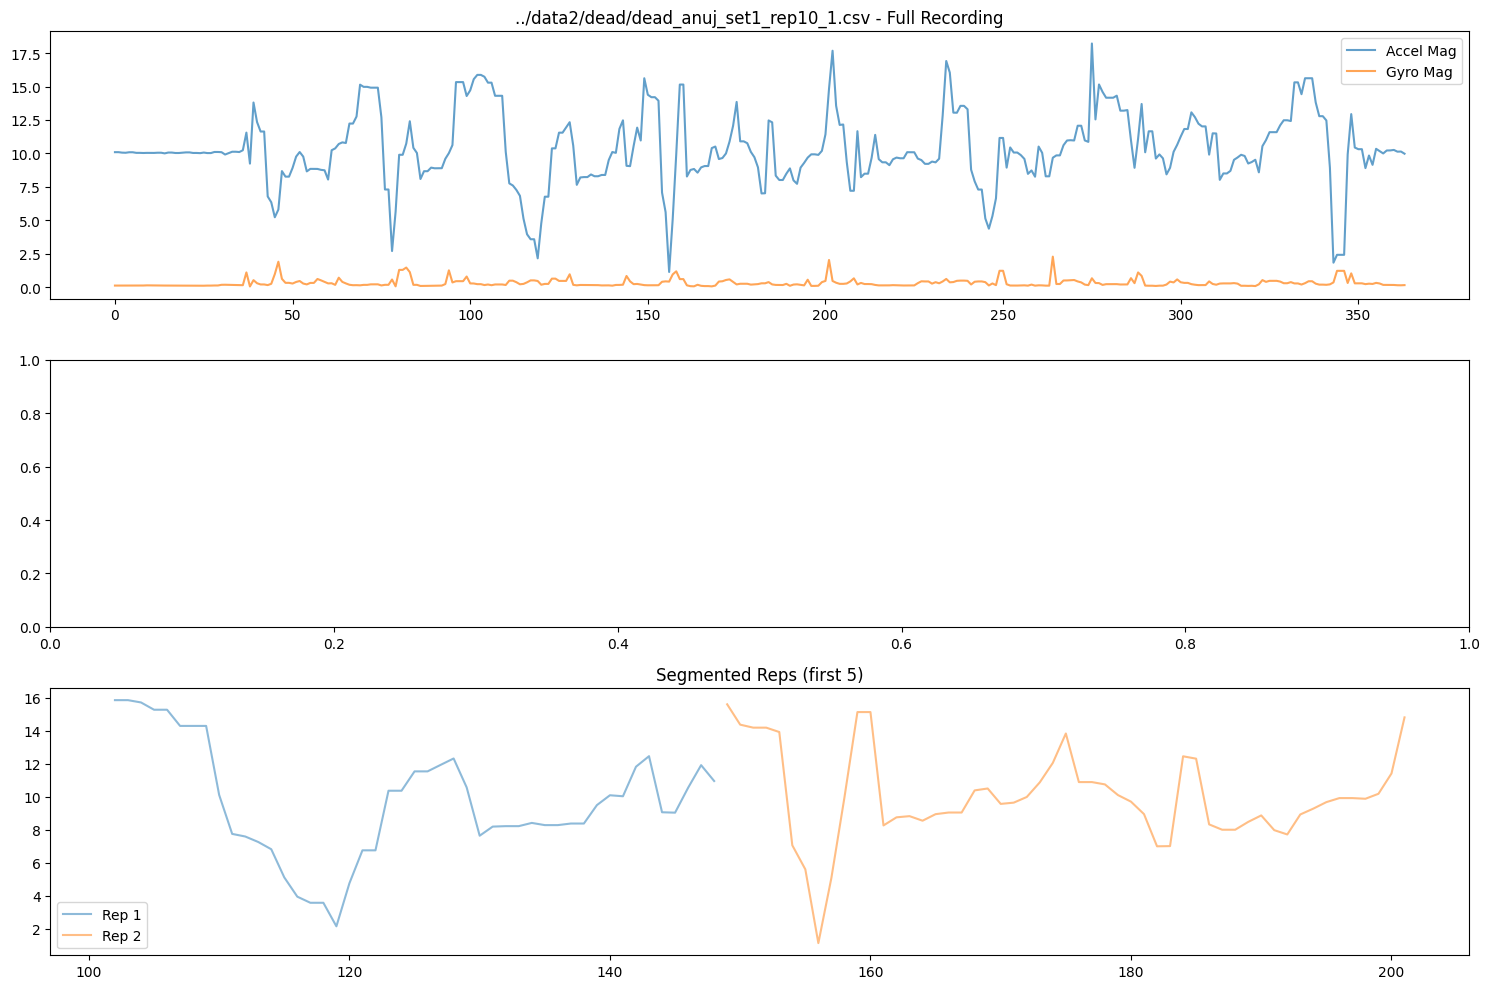

../data2/dead/dead_kamyar_set1_reps10_1.csv


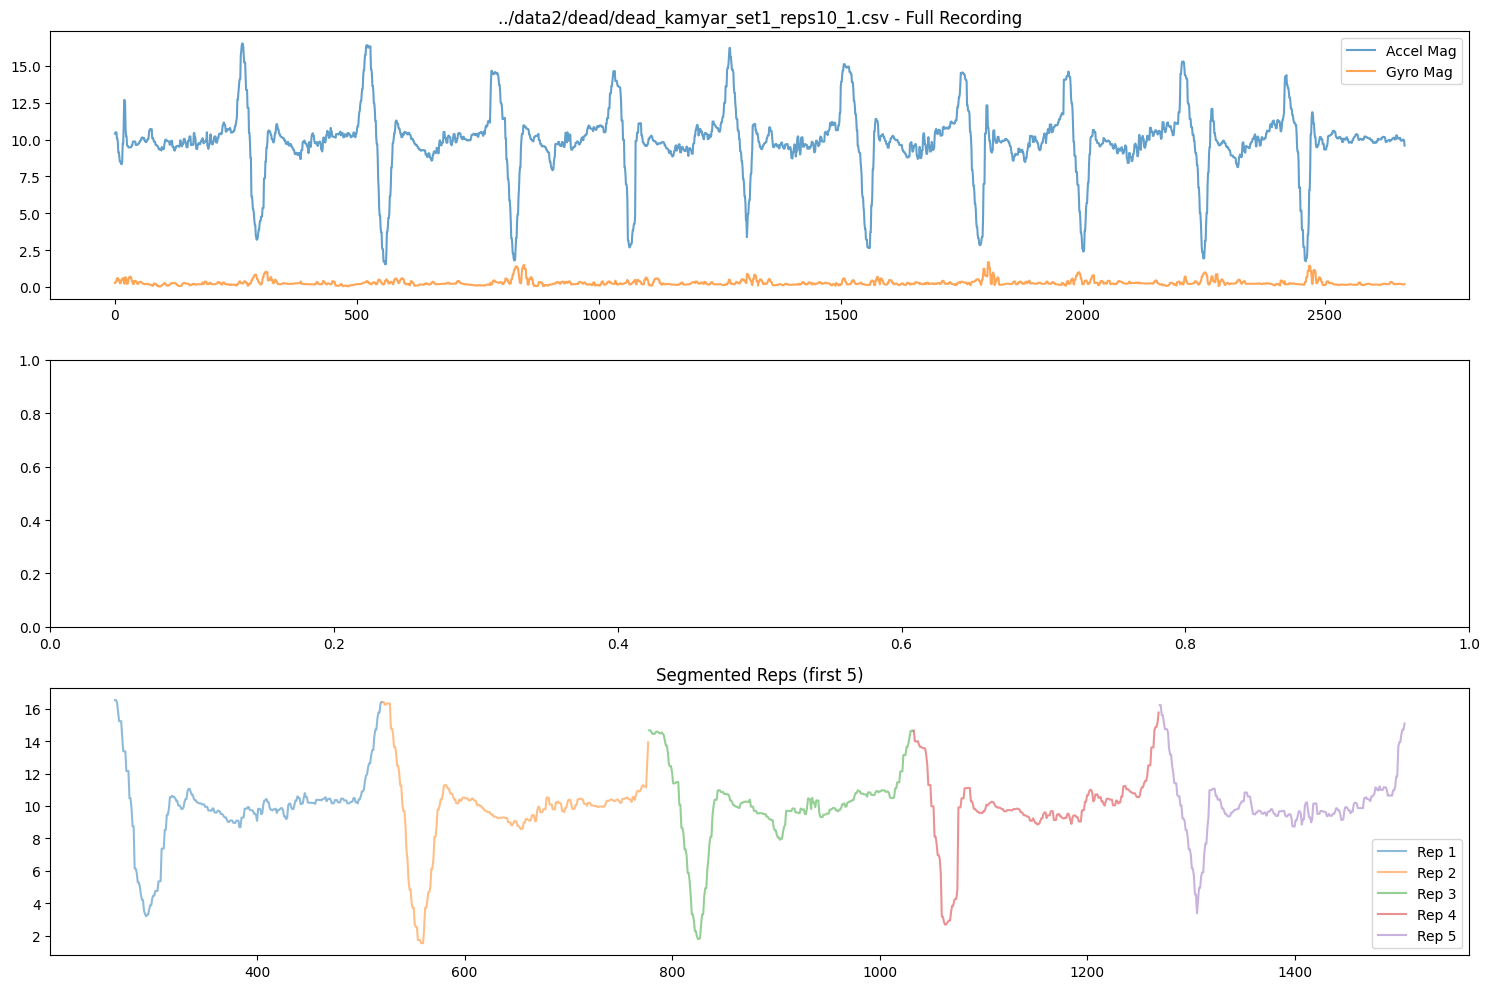

../data2/dead/dead_mike_set1_reps10_1.csv


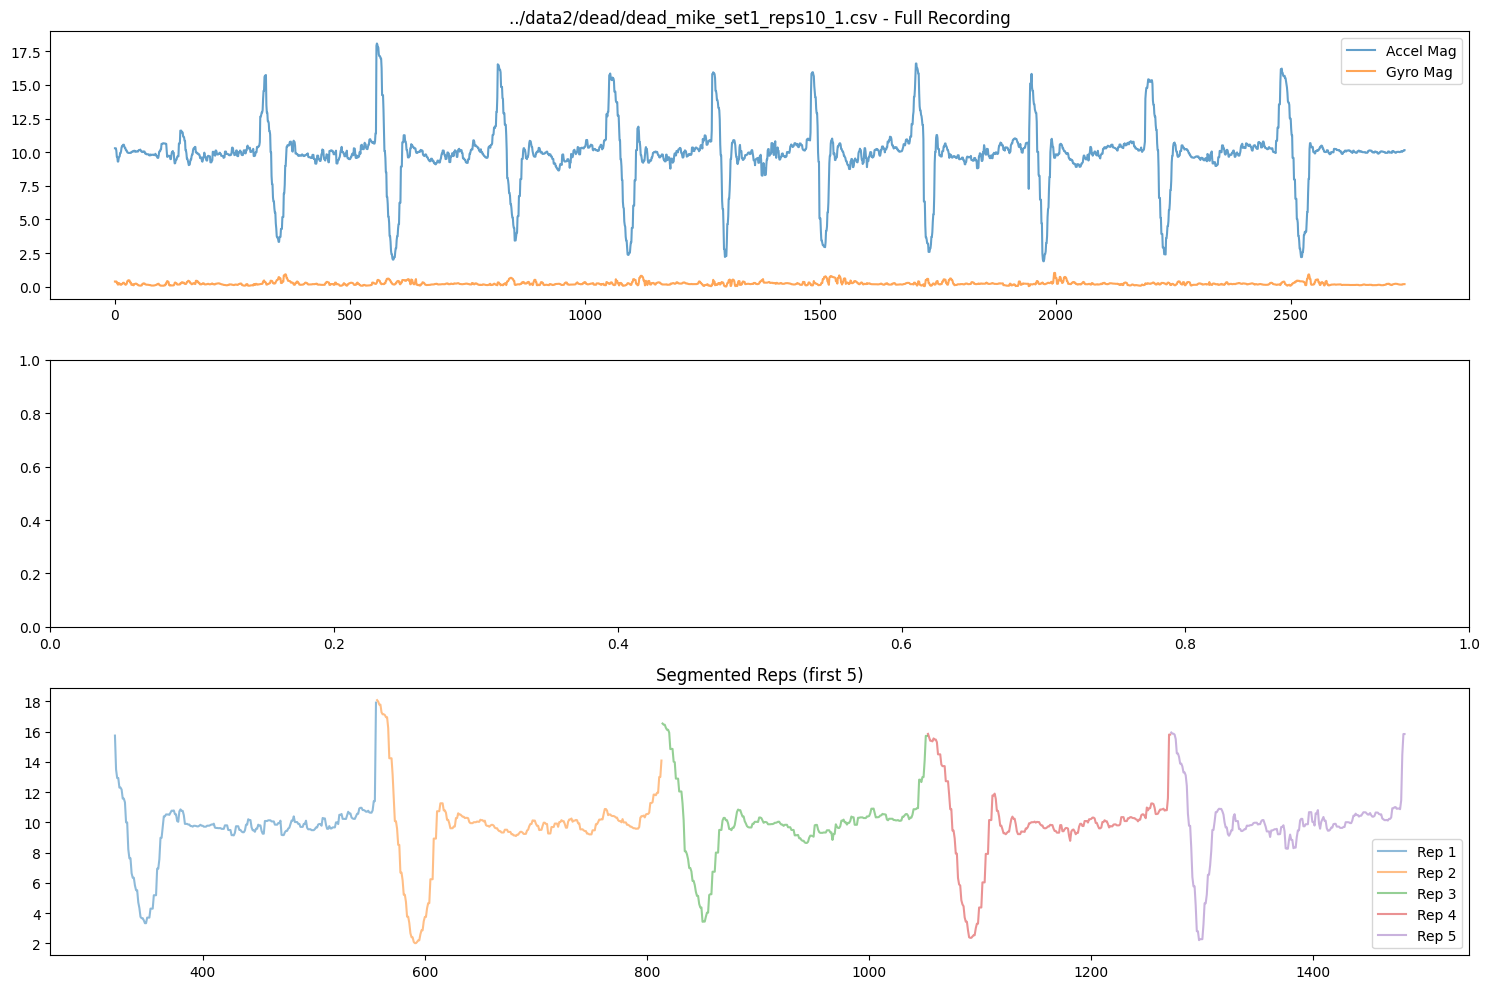

../data2/squat/squat_adam_set1_reps10_1.csv


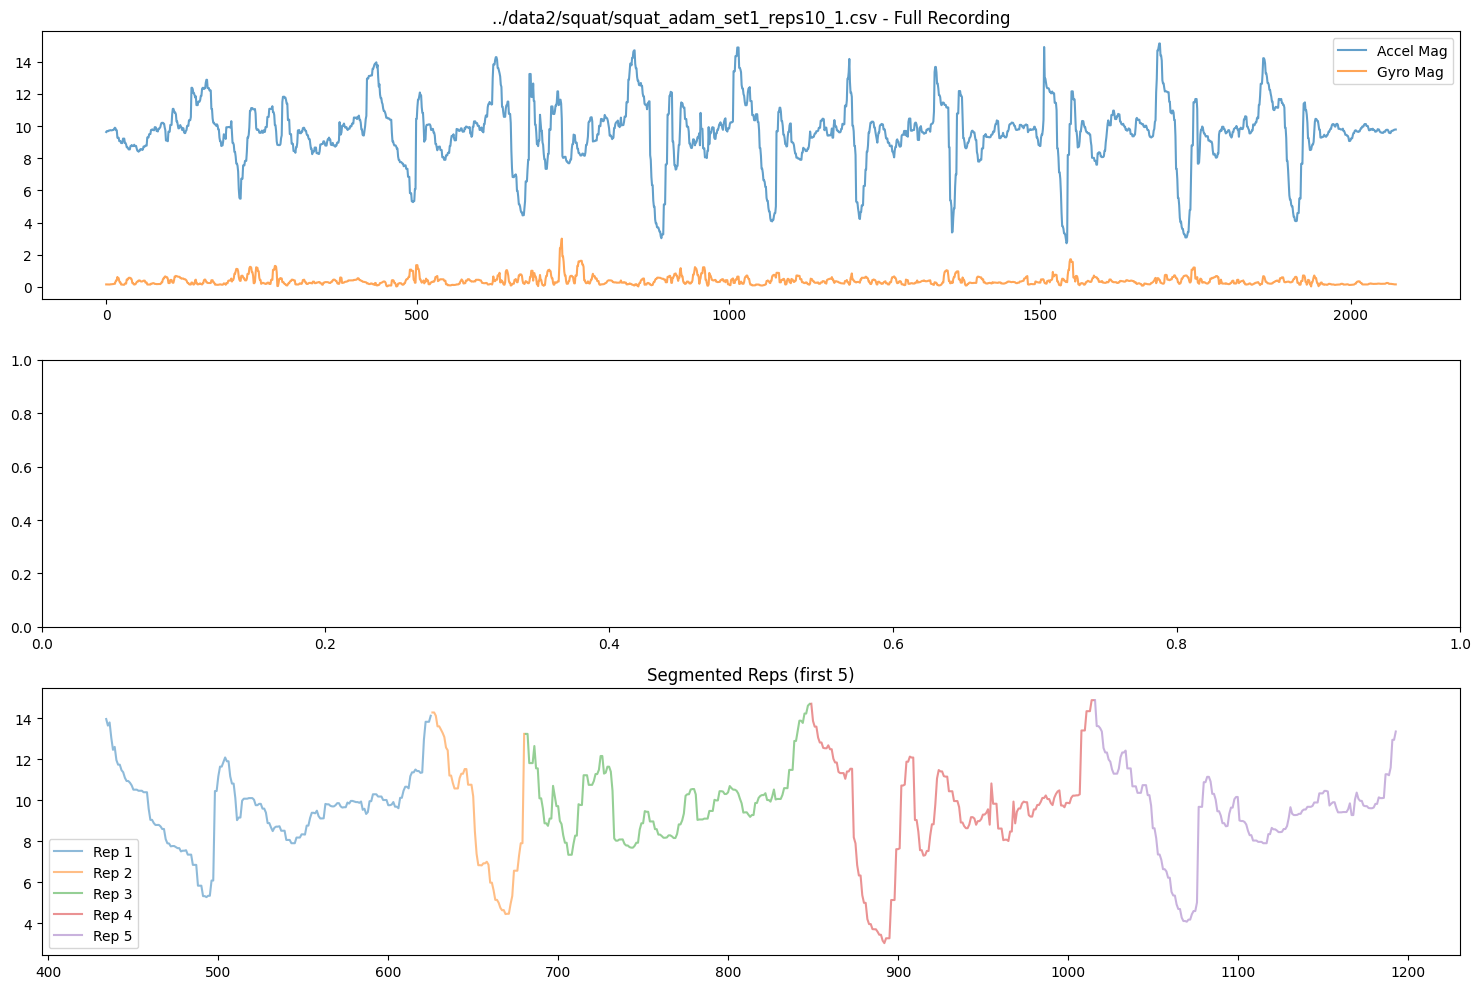

../data2/squat/squat_andrew_set1_reps10_1.csv


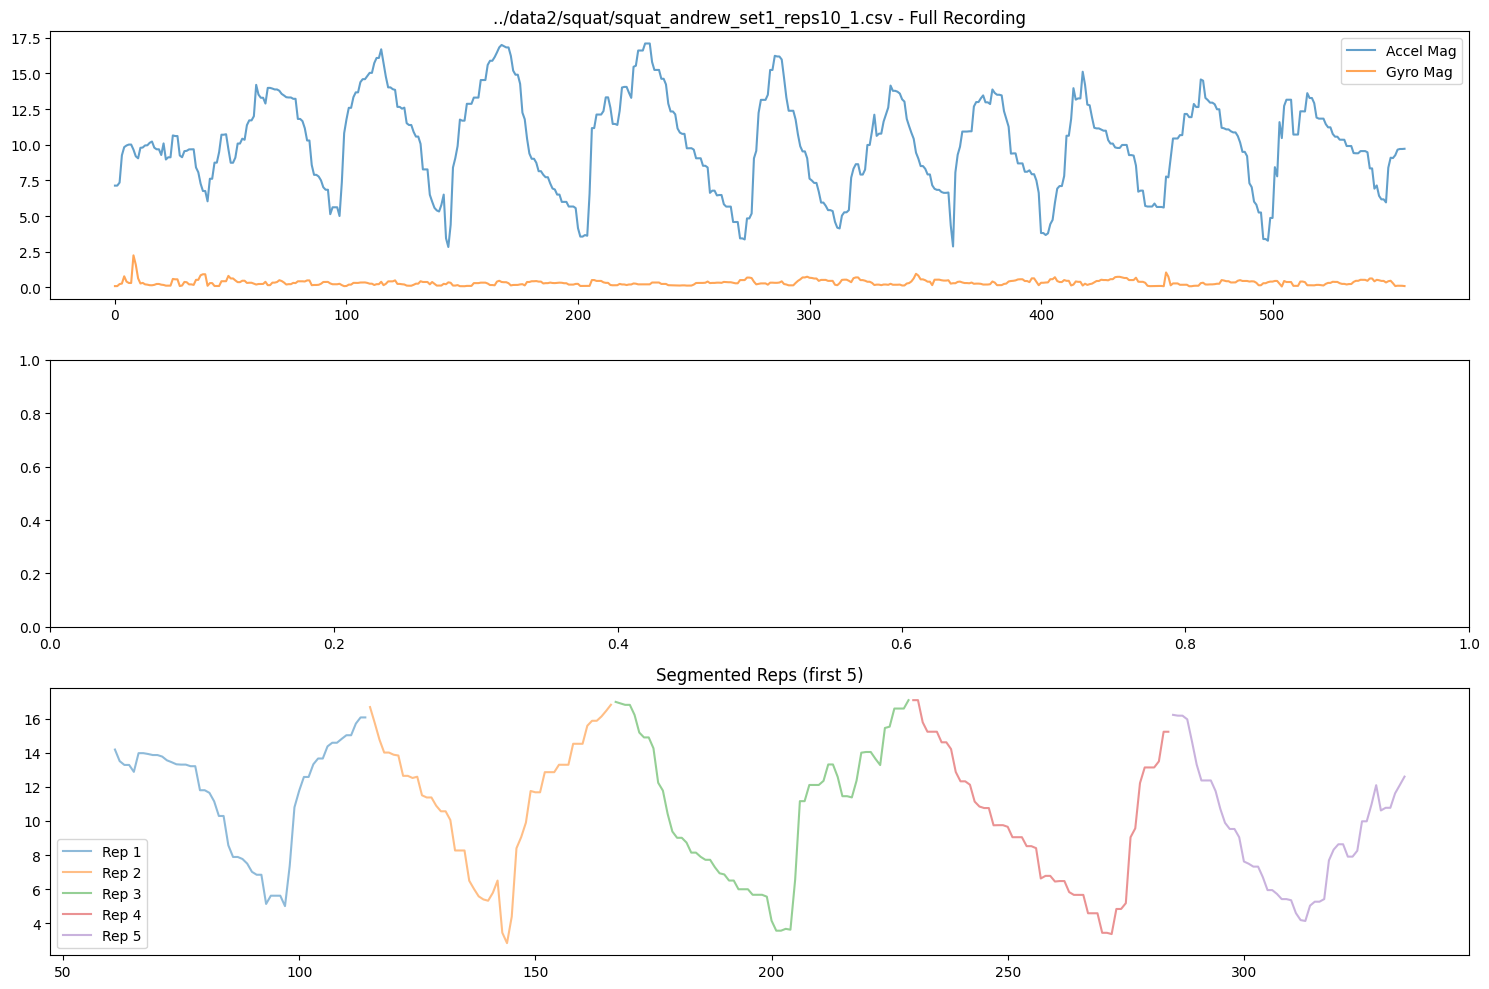

../data2/squat/squat_anuj_set1_rep10_1.csv


../data2/squat/squat_jake_set1_reps10_1.csv


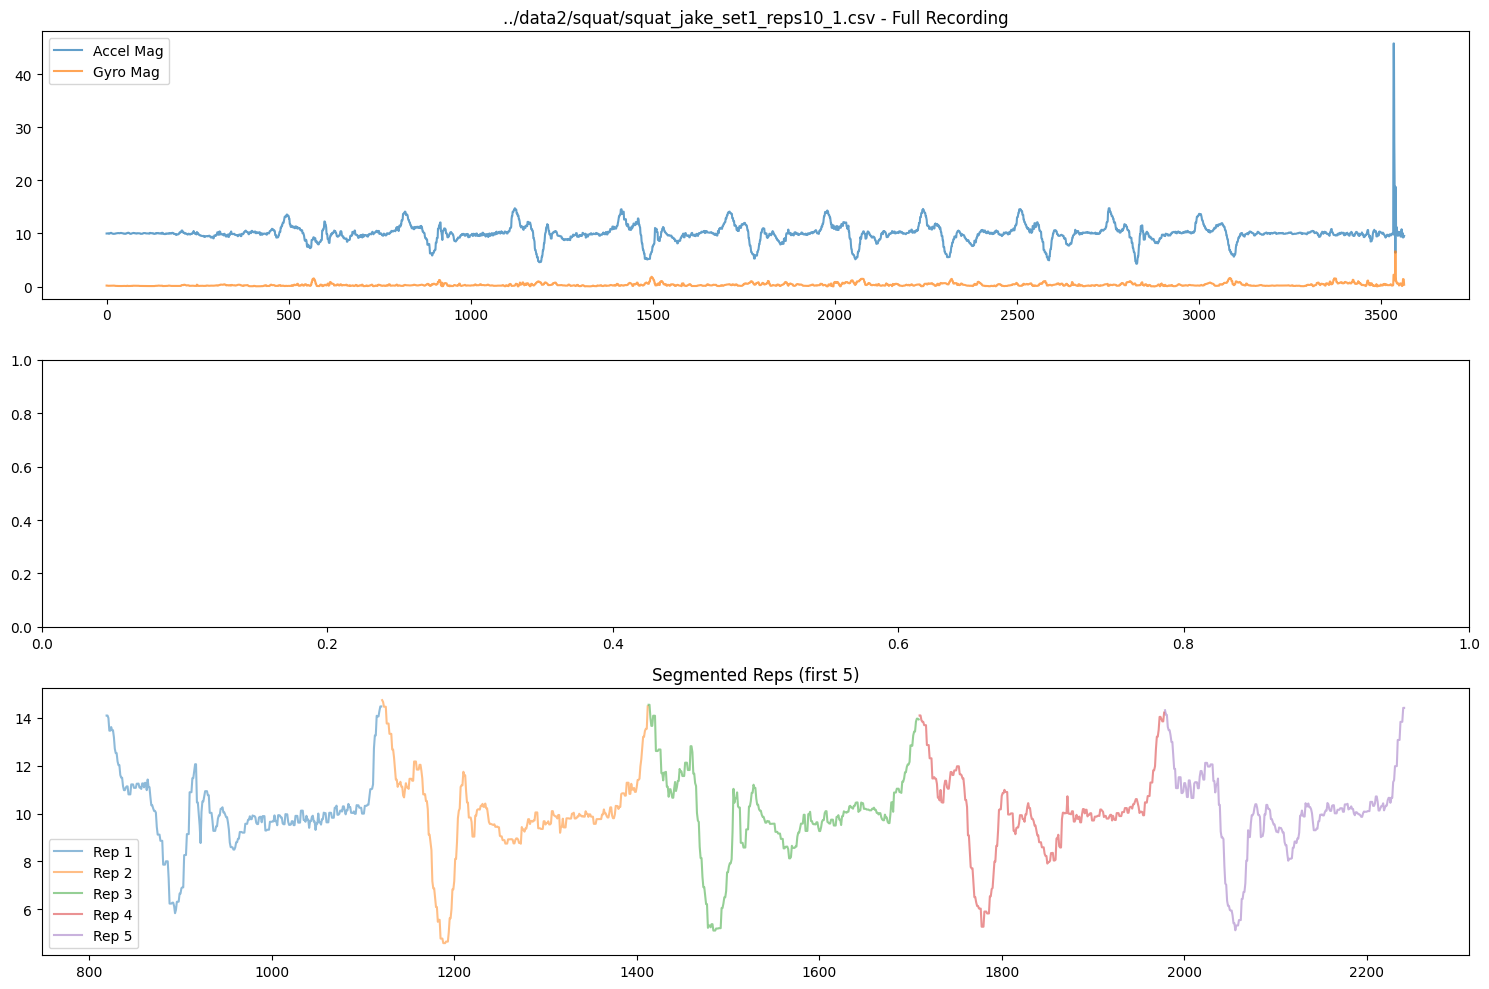

../data2/squat/squat_kamyar_set1_reps10_1.csv


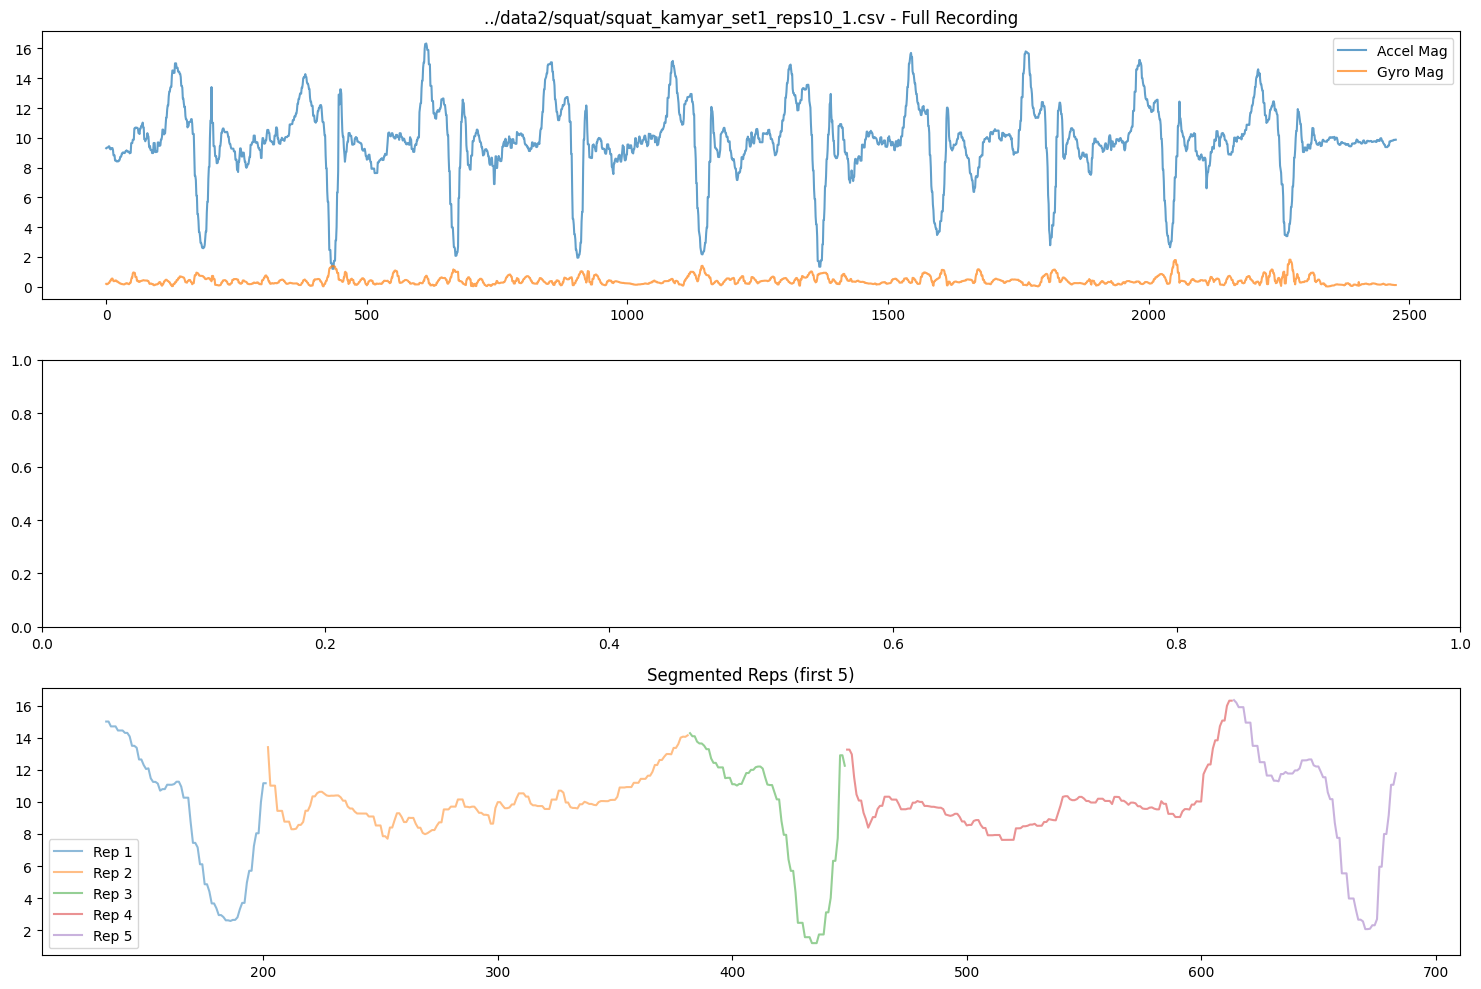

../data2/squat/squat_mike_set1_reps10_1.csv


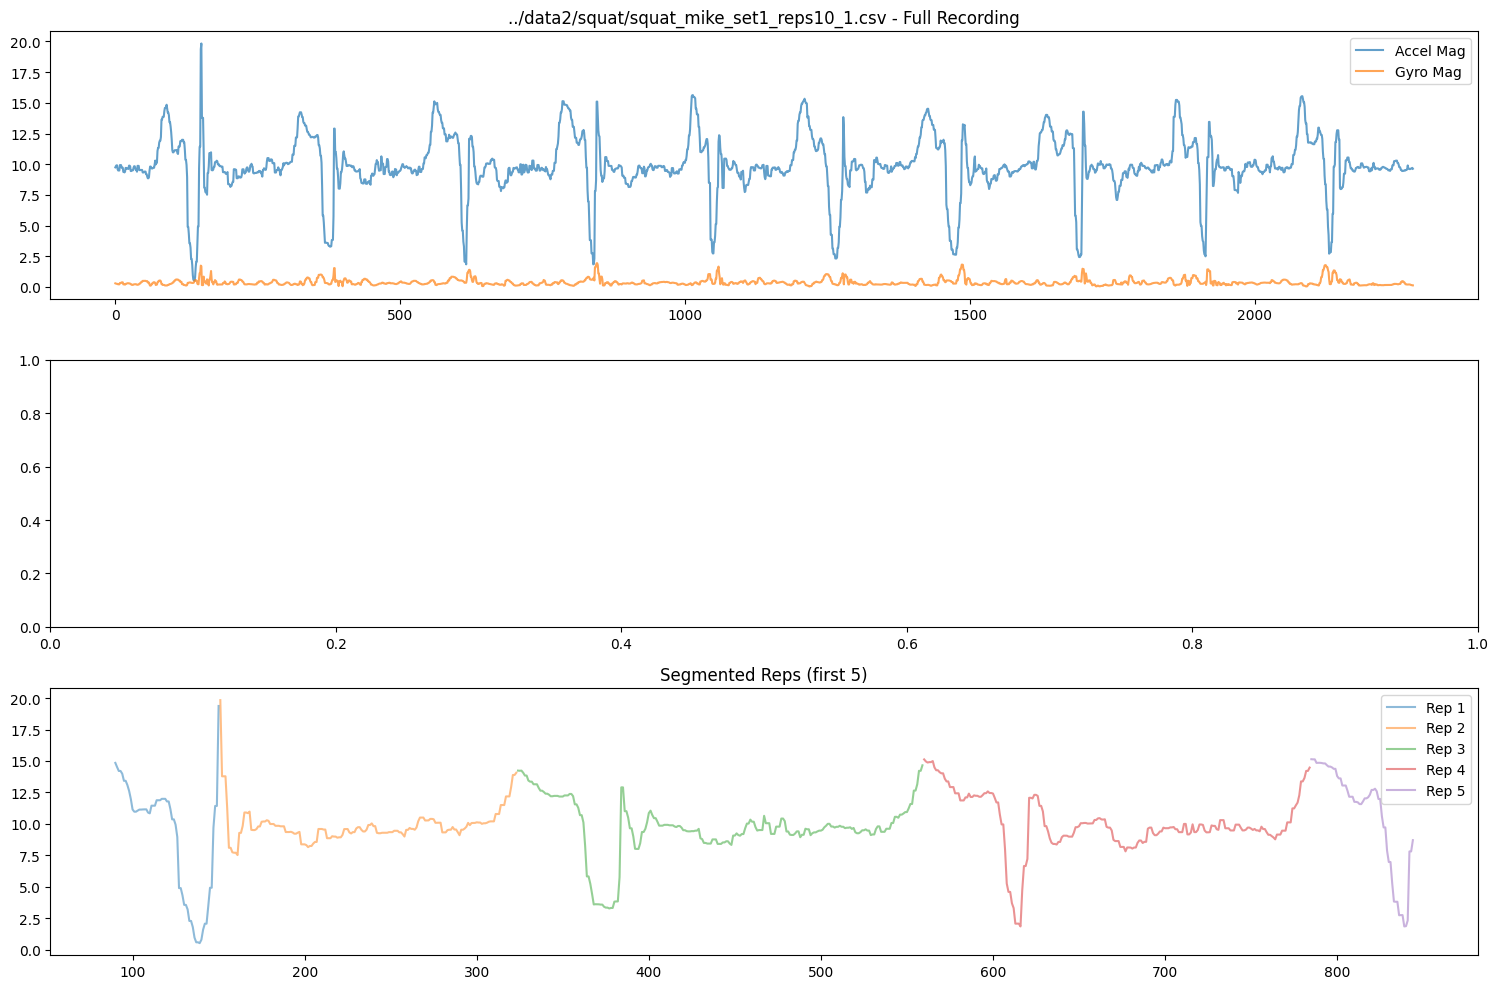

../data2/squat/squat_suzan_set1_reps10_1.csv


/var/folders/9x/nppf0cj96gl0gcz3tcx7txmm0000gn/T/ipykernel_32087/4264898585.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend()


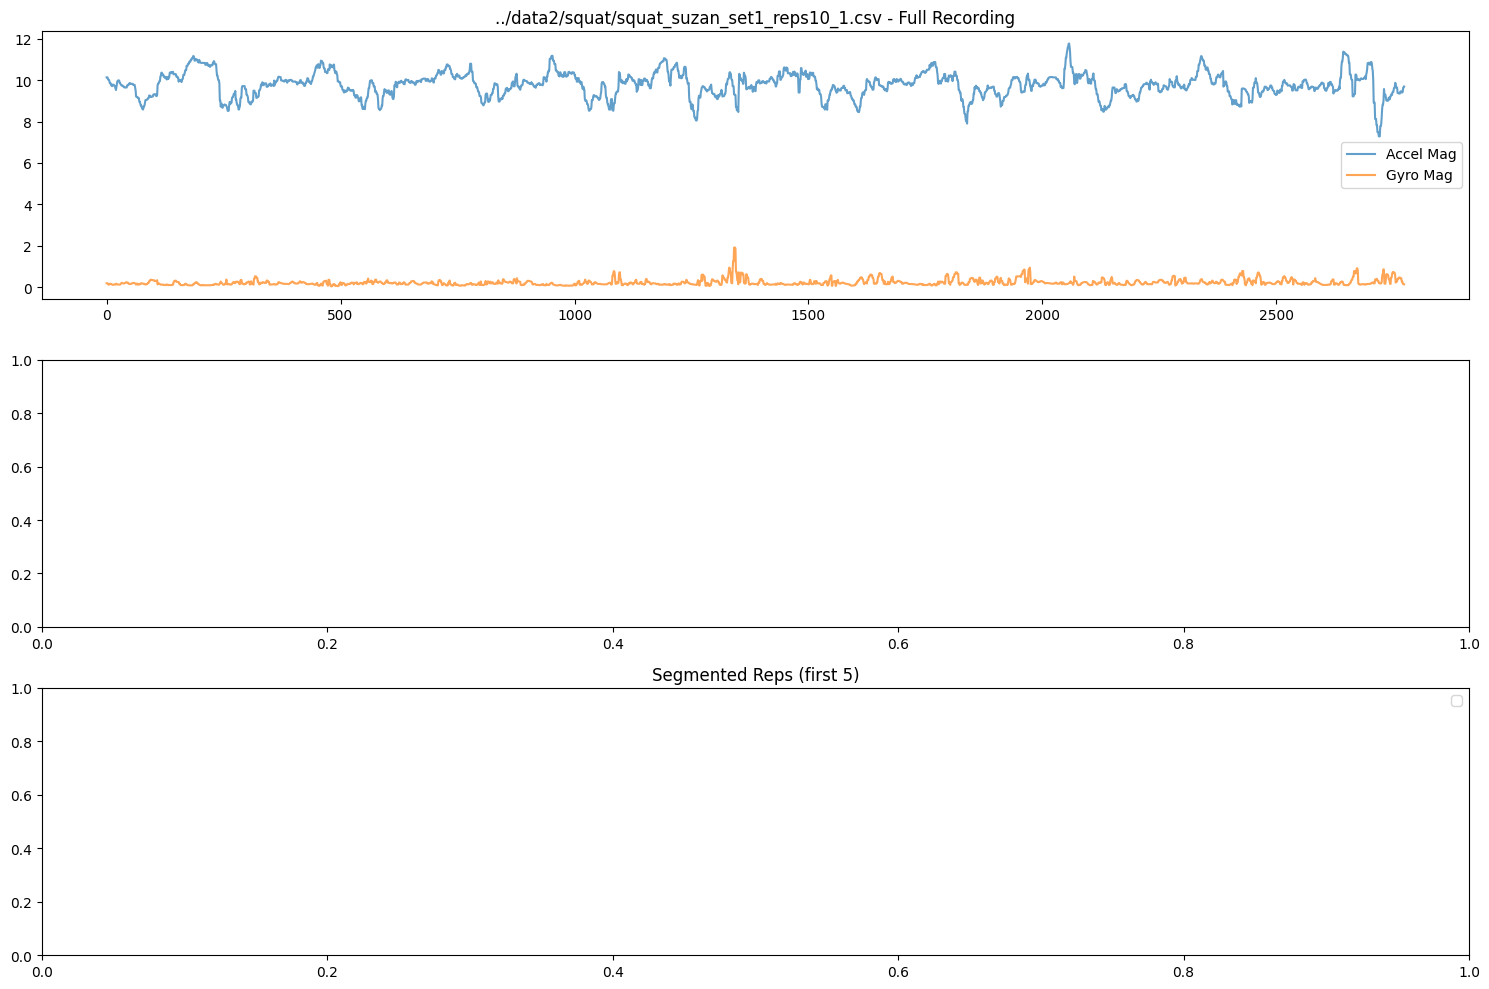

../data2/squat/squat_udai_set1_reps10_1.csv


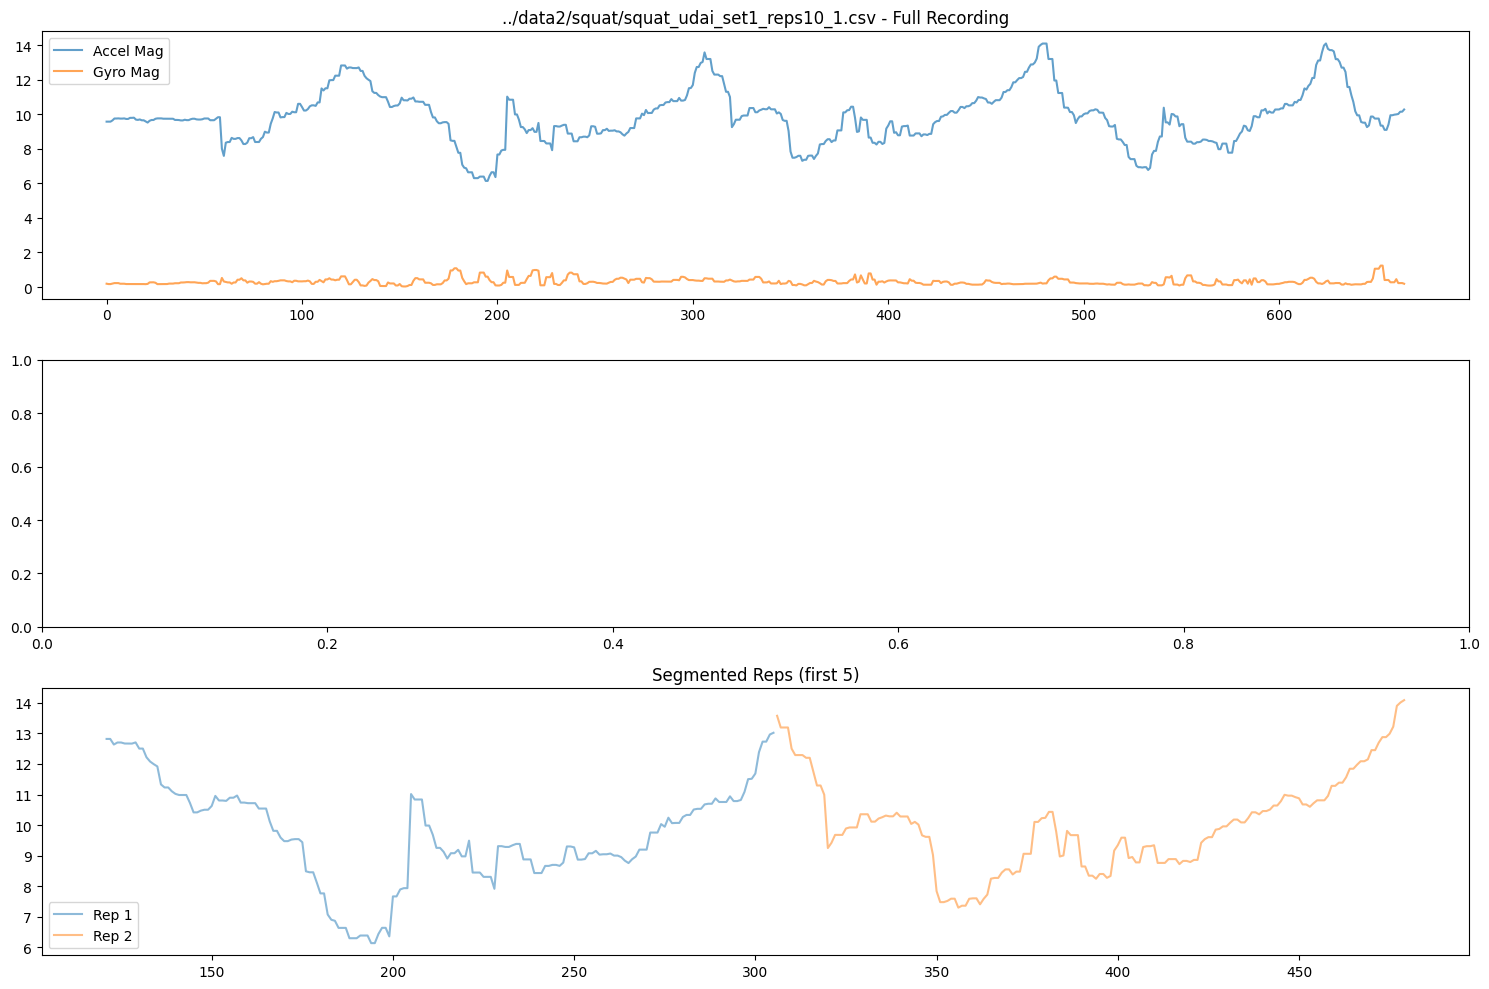

../data2/bicep_curl/bicep_udai_set3_reps10_1.csv


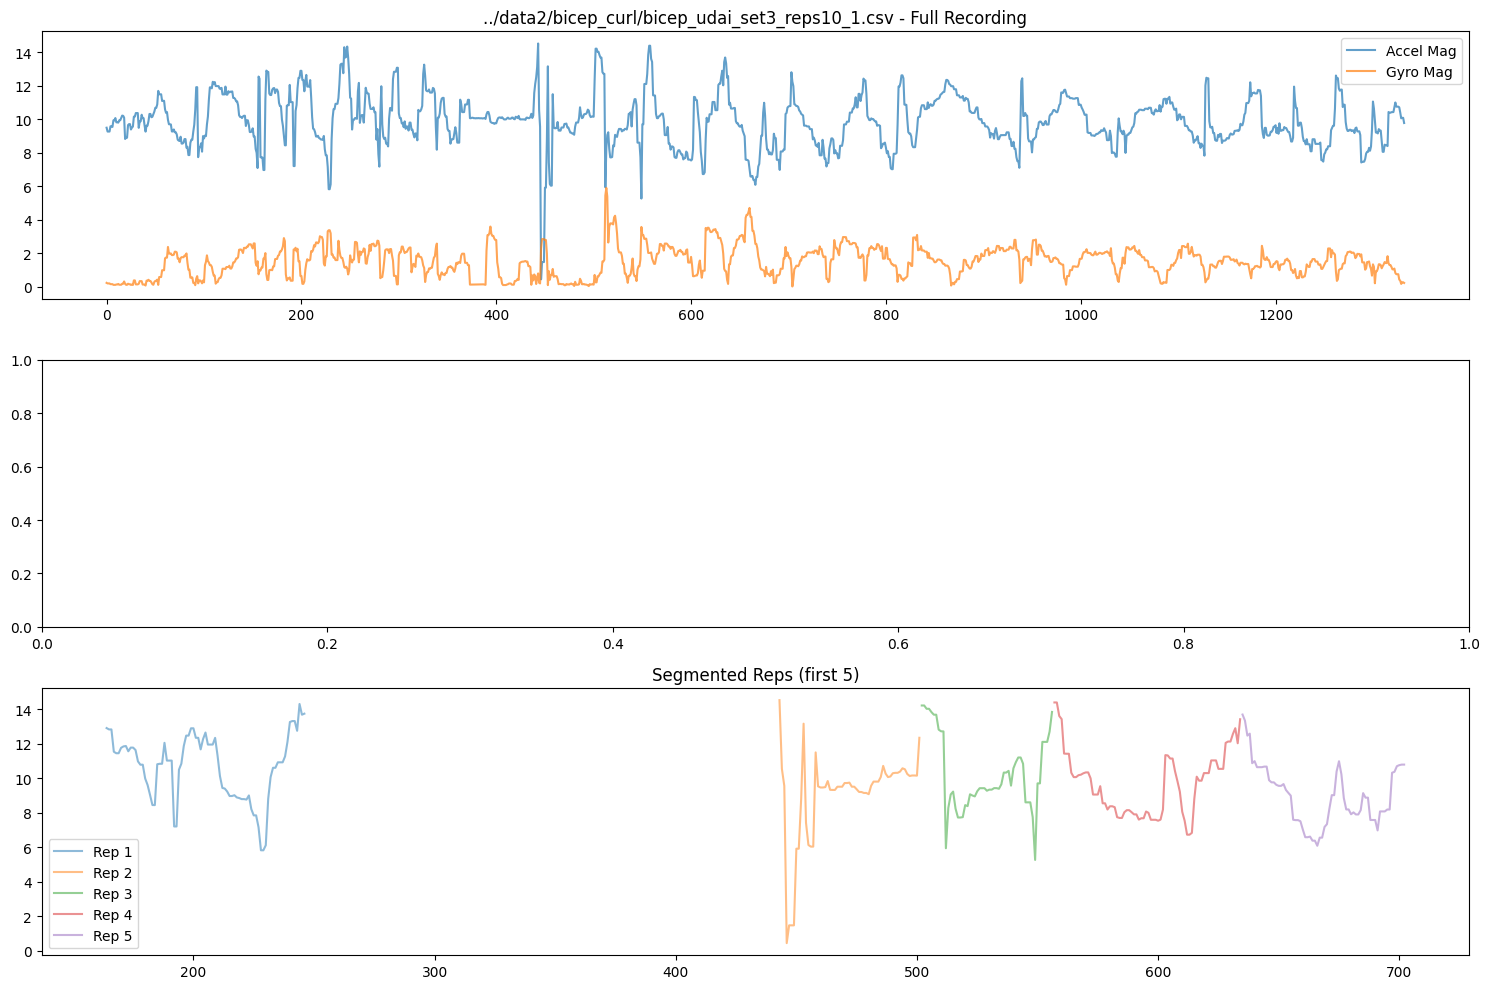

../data2/shoulder_press/shoulder_udai_set3_reps10_1.csv


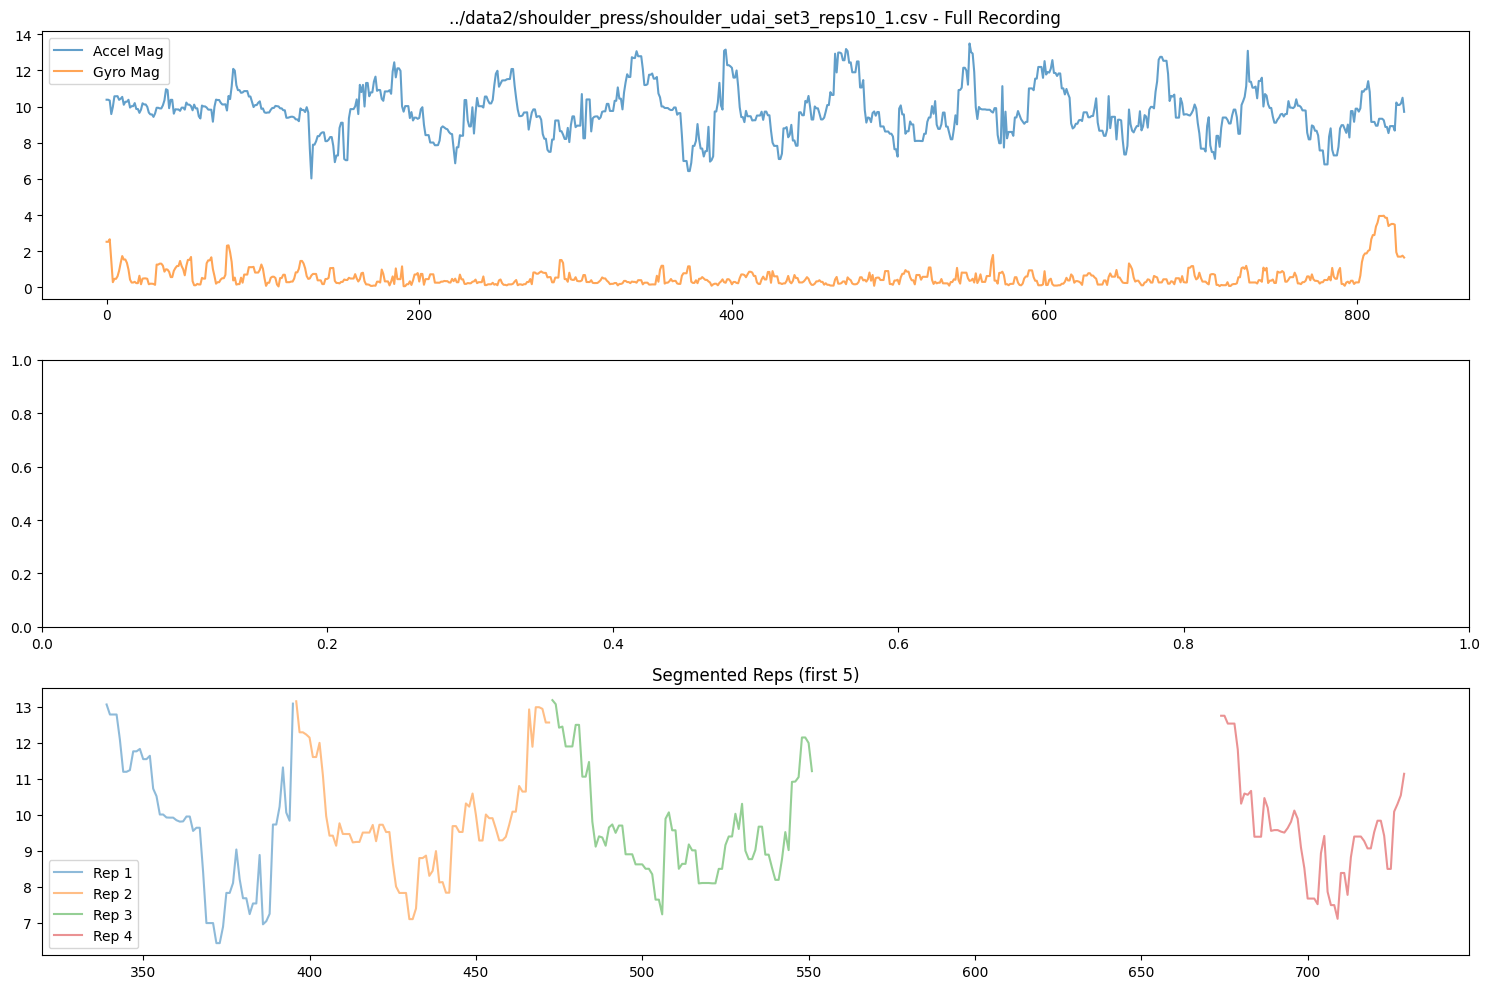

../data2/row/row_udai_set3_reps10_1.csv


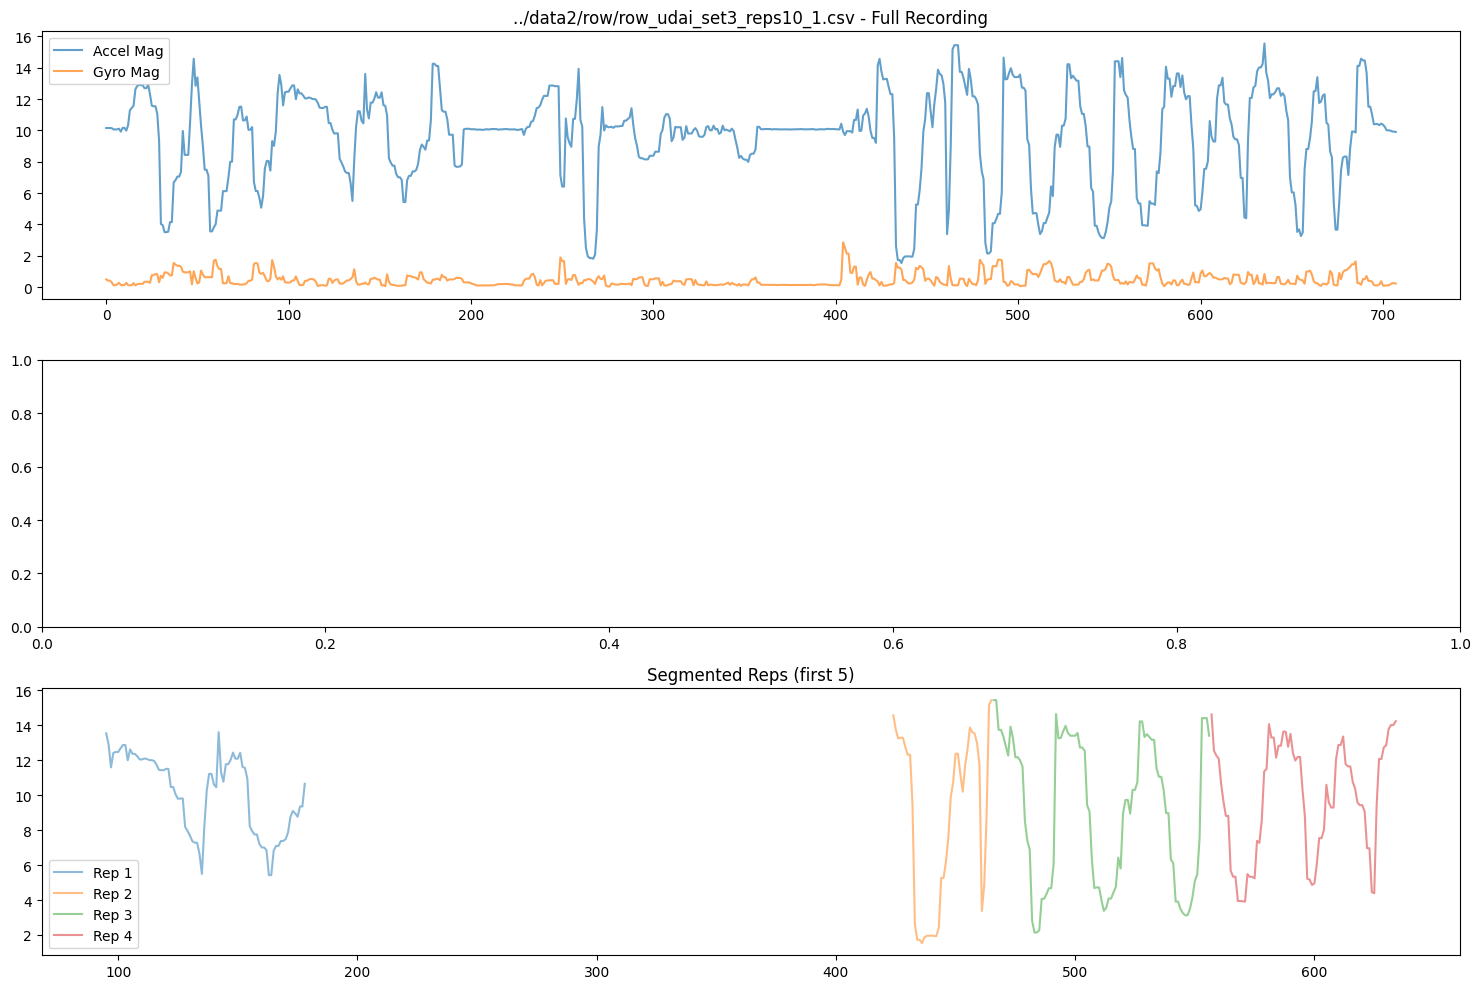

../data2/dead/dead_udai_set1_reps10_1.csv


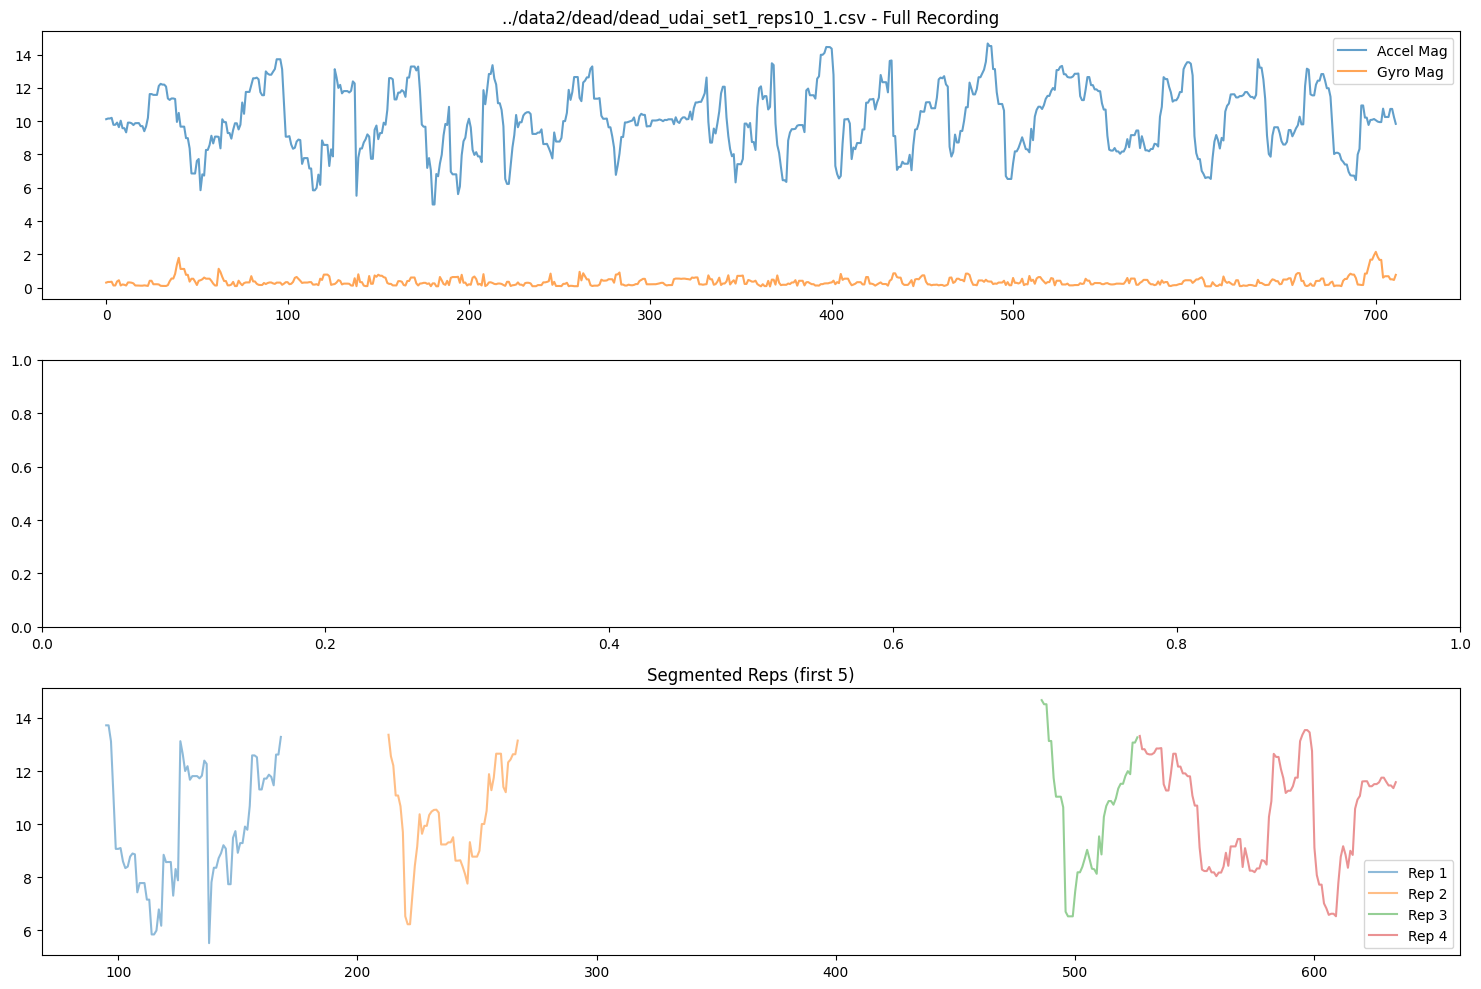

../data2/squat/squat_udai_set3_reps10_1.csv


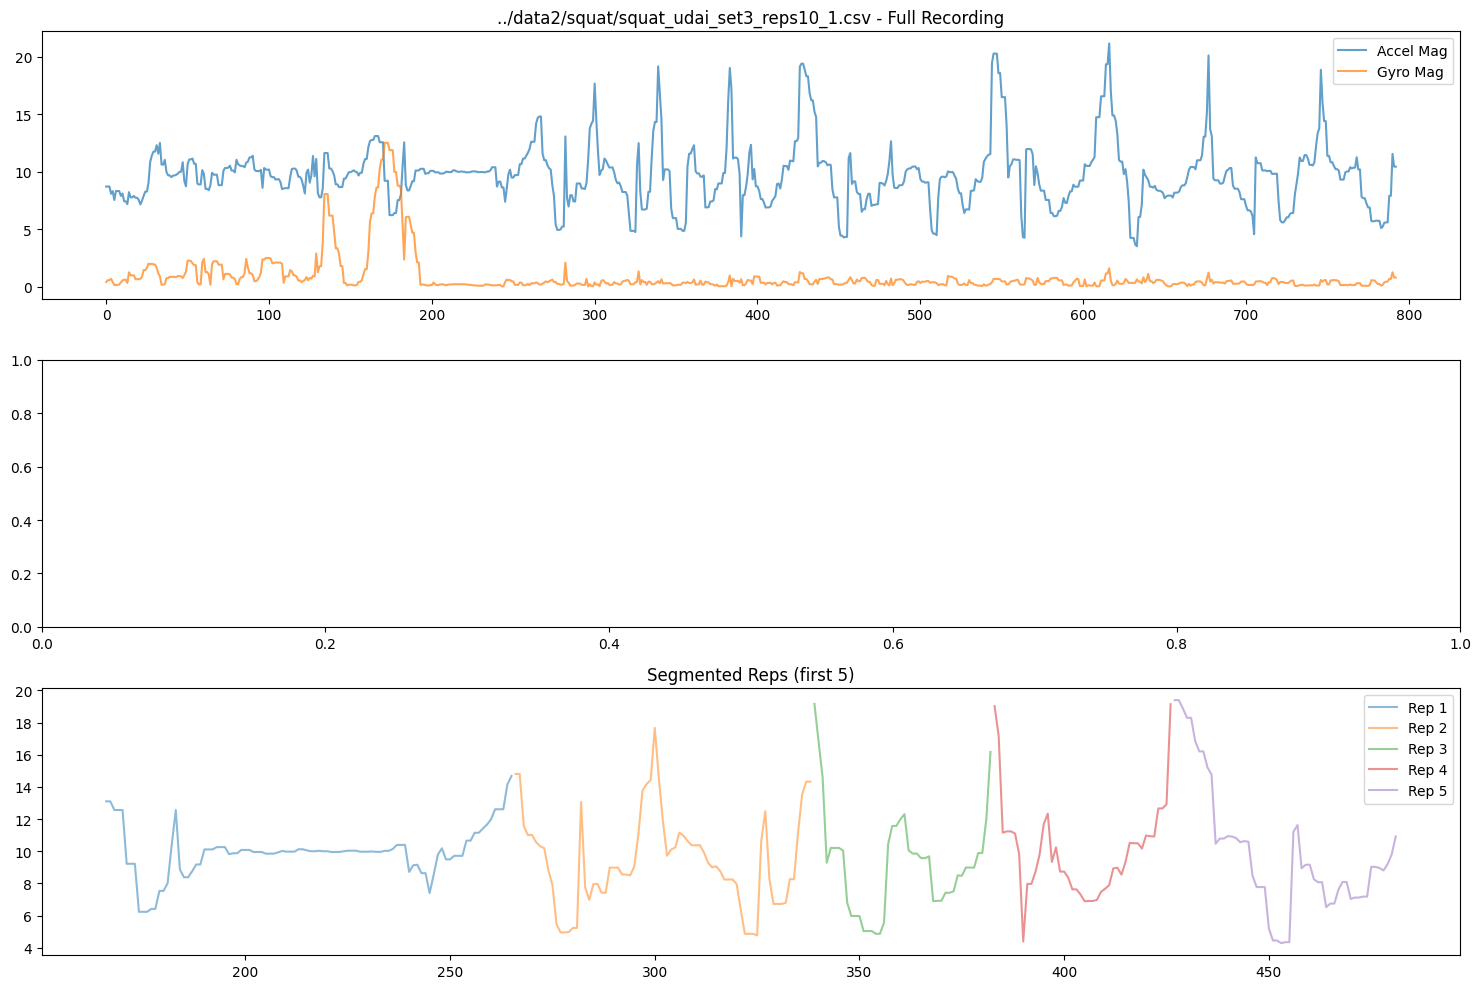

../data2/newDead/newdead_udai_set1_reps10_1.csv


../data2/newDead/newdead_udai_set2_reps10_1.csv


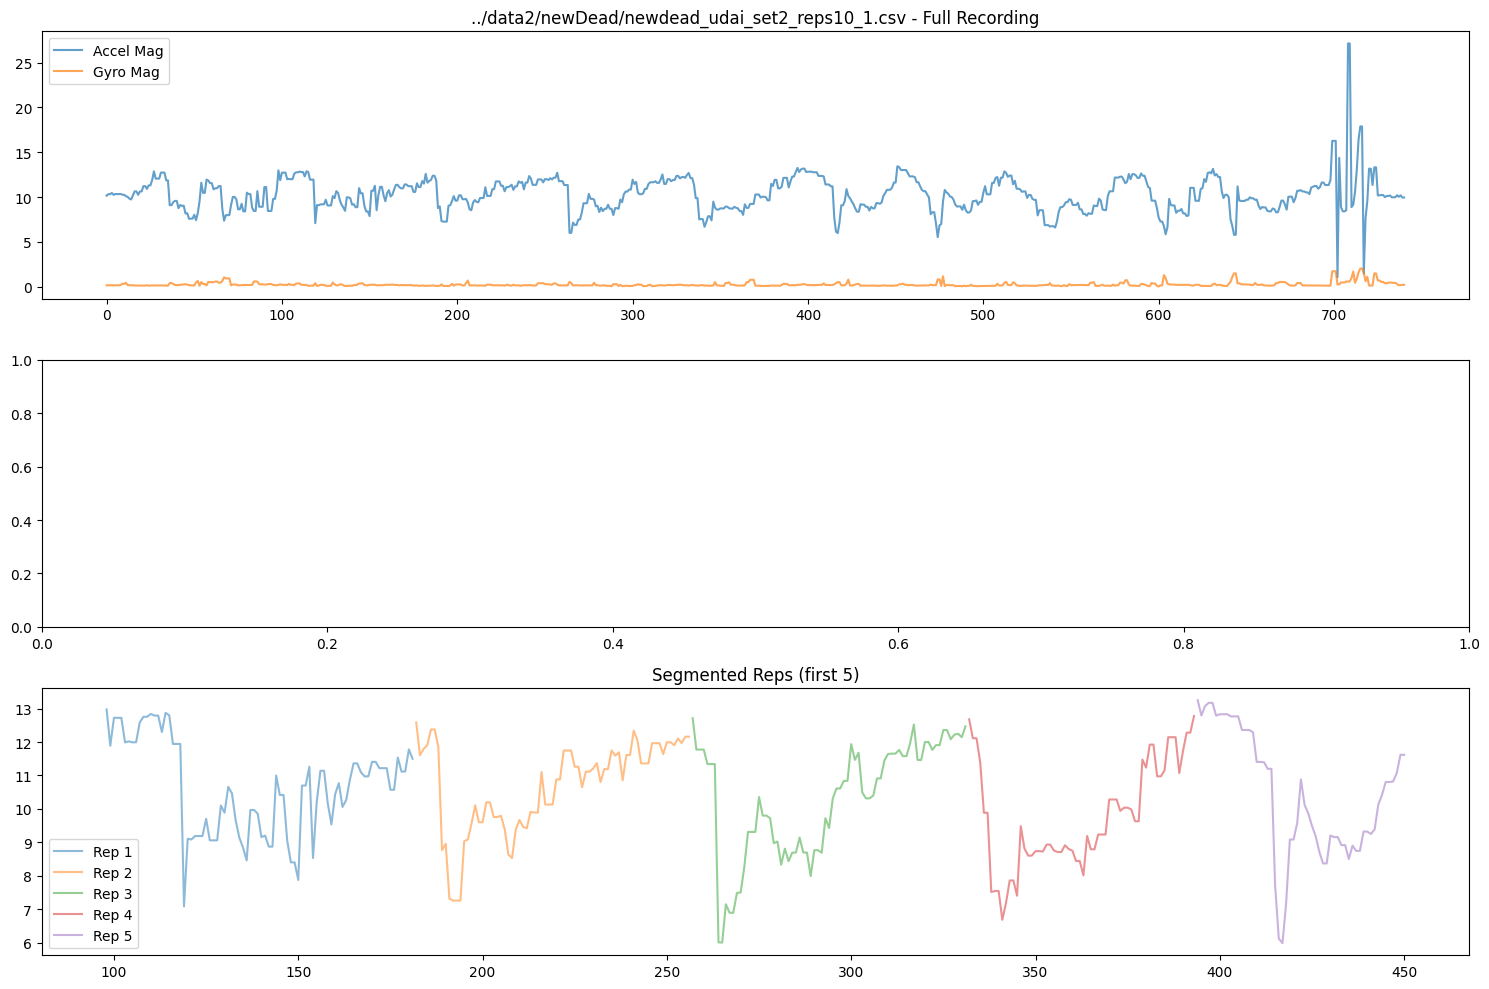

../data2/bicep_curl/bicep_adam_set2_reps10_1.csv
../data2/bicep_curl/bicep_andrew_set3_reps10_1.csv
../data2/bicep_curl/bicep_anuj_set2_rep10_1.csv
../data2/bicep_curl/bicep_jake_set2_reps10_1.csv
../data2/bicep_curl/bicep_kamyar_set2_reps10_1.csv
../data2/bicep_curl/bicep_mike_set2_reps10_1.csv
../data2/bicep_curl/bicep_suzan_set2_reps10_1.csv
../data2/bicep_curl/bicep_udai_set2_reps10_1.csv
../data2/shoulder_press/shoulder_adam_set2_reps10_1.csv
../data2/shoulder_press/shoulder_andrew_set2_reps10_1.csv
../data2/shoulder_press/shoulder_anuj_set2_rep10_1.csv
../data2/shoulder_press/shoulder_kamyar_set2_reps10_1.csv
../data2/shoulder_press/shoulder_mike_set2_reps10_1.csv
../data2/shoulder_press/shoulder_suzan_set2_reps8_1.csv
../data2/shoulder_press/shoulder_suzan_set4_reps10_1.csv
../data2/shoulder_press/shoulder_udai_set2_reps9_1.csv
../data2/row/row_adam_set2_reps10_1.csv
../data2/row/row_andrew_set2_reps10_1.csv
../data2/row/row_anuj_set2_rep10_1.csv
../data2/row/row_jake_set2_reps1

In [4]:
X_train = []
X_test = []
y_train = []
y_test = []
max_len = 100

# Iterate through each training file to add additional features and segment into reps
for file, label in training_files.items():
    df = create_df(file)
    df = add_features(df)
    #file_resampled = smooth_and_resample(df, target_len=1000)
    reps = segment_into_reps(df, min_rep_length=500, max_rep_length=5000)

    fig, axes = plt.subplots(3, 1, figsize=(15, 10))
    
    # Plot 1: Full recording with detected reps
    axes[0].plot(df['accel_mag'], label='Accel Mag', alpha=0.7)
    axes[0].plot(df['gyro_mag'], label='Gyro Mag', alpha=0.7)
    axes[0].set_title(f'{file} - Full Recording')
    axes[0].legend()
    
    # Plot 3: Individual reps overlaid
    for i, rep in enumerate(reps[:5]):  # Show first 5 reps
        axes[2].plot(rep['accel_mag'], alpha=0.5, label=f'Rep {i+1}')
    axes[2].set_title('Segmented Reps (first 5)')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # For each rep in the training files, smooth & resample them, then append
    for rep in reps:
        rep_resampled = smooth_and_resample(rep, target_len=100)
        X_train.append(rep_resampled)
        y_train.append(label)

# Iterate through each test file to add additional features and segment into reps
for file, label in test_files.items():
    df = create_df(file)
    df = add_features(df)
    #file_resampled = smooth_and_resample(df, target_len=1000)
    reps = segment_into_reps(df, min_rep_length=500, max_rep_length=5000)
    
    # For each rep in the test files, smooth & resample them, then append
    for rep in reps:
        rep_resampled = smooth_and_resample(rep, target_len=100)
        X_test.append(rep_resampled)
        y_test.append(label)

rep_lengths = [len(rep) for rep in X_train + X_test]
target_length = int(np.median(rep_lengths))

In [5]:
print(f"max_len: {max_len}")

def pad(df, max_len):
    
    arr = df.drop('timestamp', axis=1).to_numpy()
    
    if len(arr) >= max_len:
        return arr[:max_len]
    else:
        pad_len = max_len - len(arr)
        pad = np.zeros((pad_len, len(arr[0])))
        return np.vstack((arr, pad))


max_len: 100


In [6]:
X_train = np.array([pad(df, target_length) for df in X_train])
X_test = np.array([pad(df, target_length) for df in X_test])

X_train = np.stack(X_train, axis=0)
X_test = np.stack(X_test, axis=0)

print(f"training_files.values(): {list(training_files.values())}")

num_classes = 5
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

training_files.values(): [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 1, 2, 3, 4, 3, 3]


In [7]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 96, 64)         │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 48, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,869 (612.77 KB)

 Trainable params: 156,741 (612.27 KB)

 Non-trainable params: 128 (512.00 B)

In [8]:
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [9]:
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

model.load_weights(checkpoint_filepath)

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4880 - loss: 1.3899 - val_accuracy: 0.1270 - val_loss: 1.6181
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6200 - loss: 1.0517 - val_accuracy: 0.1429 - val_loss: 1.6687
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7200 - loss: 0.8390 - val_accuracy: 0.1905 - val_loss: 1.7198
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7240 - loss: 0.7043 - val_accuracy: 0.2381 - val_loss: 1.8495
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8240 - loss: 0.5162 - val_accuracy: 0.2698 - val_loss: 2.0269
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8440 - loss: 0.4538 - val_accuracy: 0.3175 - val_loss: 2.2946
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8320 - loss: 0.4529 - val_accuracy: 0.1905 - val_loss: 2.3813
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8640 - loss: 0.3696 - val_accuracy: 0.2698 - val_loss: 2.0919


In [10]:
cnn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    Conv1D(64, kernel_size=7, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(128, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling1D(),

    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 94, 64)         │         5,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 94, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 47, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 43, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 43, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 19, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,421 (704.77 KB)

 Trainable params: 179,525 (701.27 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5560 - loss: 1.0691 - val_accuracy: 0.0794 - val_loss: 1.5541
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7640 - loss: 0.6189 - val_accuracy: 0.3492 - val_loss: 1.5983
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8080 - loss: 0.4991 - val_accuracy: 0.2857 - val_loss: 1.9222
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8600 - loss: 0.4112 - val_accuracy: 0.1270 - val_loss: 2.1713
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9080 - loss: 0.2760 - val_accuracy: 0.1587 - val_loss: 2.5574
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8760 - loss: 0.3616 - val_accuracy: 0.1429 - val_loss: 2.5167
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9120 - loss: 0.2346 - val_accuracy: 0.3492 - val_loss: 2.2838
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9240 - loss: 0.1833 - val_accuracy: 0.3016 - val_loss: 2.64

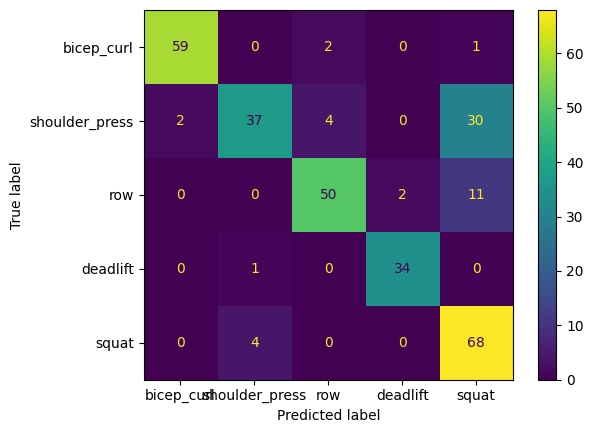

In [11]:
cnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

# cnn_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(cnn_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)

class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [12]:
hybrid_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    Conv1D(64, 5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),

    Bidirectional(LSTM(64)),
    Dropout(0.2),

    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hybrid_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 96, 64)         │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 96, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 48, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 48, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 374,725 (1.43 MB)

 Trainable params: 374,597 (1.43 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.4640 - loss: 1.2561 - val_accuracy: 0.0952 - val_loss: 1.8398
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7200 - loss: 0.7734 - val_accuracy: 0.1270 - val_loss: 1.9559
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7920 - loss: 0.5237 - val_accuracy: 0.2381 - val_loss: 2.2103
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8400 - loss: 0.4223 - val_accuracy: 0.1746 - val_loss: 2.5561
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9080 - loss: 0.3305 - val_accuracy: 0.1587 - val_loss: 2.8409
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8960 - loss: 0.2916 - val_accuracy: 0.3016 - val_loss: 2.8518
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9000 - loss: 0.2820 - val_accuracy: 0.2381 - val_loss: 2.8004
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9360 - loss: 0.1743 - val_accuracy: 0.3175 - val_loss:

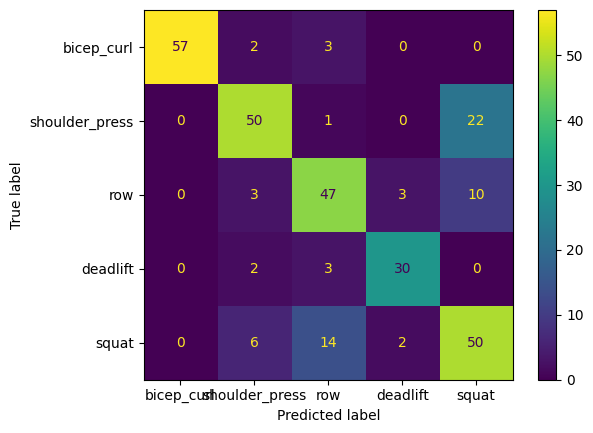

In [13]:
hybrid_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

# hybrid_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(hybrid_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [14]:
tcn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    TCN(nb_filters=64, kernel_size=5, dropout_rate=0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

tcn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
tcn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn (TCN)                       │ (None, 64)             │       230,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 239,685 (936.27 KB)

 Trainable params: 239,685 (936.27 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
tcn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.2480 - loss: 31.3318 - val_accuracy: 0.3492 - val_loss: 4.2392
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3200 - loss: 7.4572 - val_accuracy: 0.1111 - val_loss: 3.3171
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3160 - loss: 4.9056 - val_accuracy: 0.1587 - val_loss: 2.7760
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4080 - loss: 2.8503 - val_accuracy: 0.2857 - val_loss: 2.1429
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3760 - loss: 2.5916 - val_accuracy: 0.1270 - val_loss: 2.4567
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4720 - loss: 1.9944 - val_accuracy: 0.1746 - val_loss: 2.2861
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4680 - loss: 1.8832 - val_accuracy: 0.3175 - val_loss: 2.0042
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5000 - loss: 1.6028 - val_accuracy: 0.2857 - val_loss: 1.8612

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
y_pred: [0 0 0 0 0 0 0 0 1 4 4 0 0 0 0 0 0 0 0 0 2 0 2 0 2 0 0 4 0 4 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 1 4 1 1 4 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 1 1 1 1 1 1
 1 1 1 1 4 4 4 4 4 4 4 4 2 4 1 1 1 1 1 1 4 4 4 2 2 2 2 2 2 2 2 2 3 2 2 3 3
 3 2 4 1 4 1 1 4 1 4 4 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2
 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 4 2 2 2 3 1 1 3 3 3 3 3 3 2 3
 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 1 1 4 1 2 2 2
 2 2 2 2 2 2 2 4 1 1 1 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2
 2 2 1 2 1 1 1 1 1]
y_true: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2

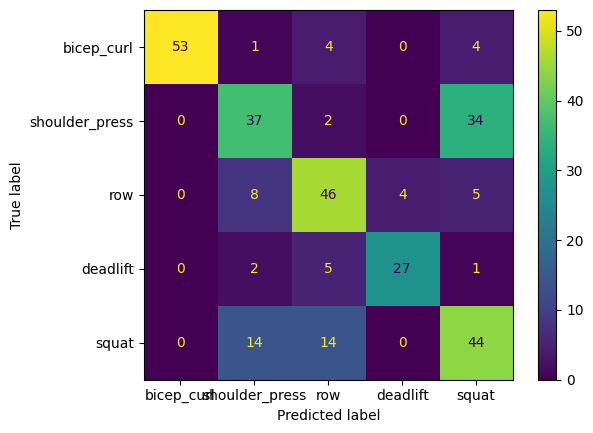

In [16]:
# tcn_model(np.zeros((1, X_train.shape[1], X_train.shape[2])))
# tcn_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(tcn_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [17]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

x = MultiHeadAttention(num_heads=4, key_dim=32)(input_layer, input_layer)
x = LayerNormalization()(x)

x = Dense(128, activation='relu')(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)

output = Dense(num_classes, activation='softmax')(x)

transformer_model = tf.keras.Model(input_layer, output)

transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transformer_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 100, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 12)   │      6,540 │ input_layer_4[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 100, 12)   │         24 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 100, 128)  │      1,664 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ dense_8[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 5)         │        645 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,873 (34.66 KB)

 Trainable params: 8,873 (34.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3560 - loss: 1.3853 - val_accuracy: 0.0635 - val_loss: 1.5890
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5720 - loss: 1.1513 - val_accuracy: 0.0952 - val_loss: 1.6318
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6000 - loss: 1.0449 - val_accuracy: 0.0952 - val_loss: 1.5904
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6280 - loss: 0.9338 - val_accuracy: 0.0952 - val_loss: 1.6558
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6400 - loss: 0.8546 - val_accuracy: 0.0952 - val_loss: 1.7649
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6520 - loss: 0.8050 - val_accuracy: 0.0952 - val_loss: 1.7833
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7200 - loss: 0.7252 - val_accuracy: 0.0952 - val_loss: 1.8455
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7040 - loss: 0.6919 - val_accuracy: 0.1111 - val_loss: 1.8525


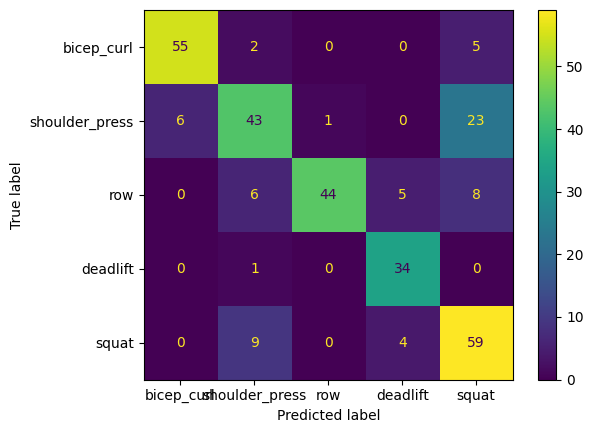

In [18]:
transformer_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

# transformer_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(transformer_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [19]:
gru_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    GRU(128, return_sequences=True),
    Dropout(0.3),

    GRU(64),
    Dropout(0.2),

    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gru_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 100, 128)       │        54,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,261 (376.02 KB)

 Trainable params: 96,261 (376.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.4160 - loss: 1.4277 - val_accuracy: 0.0794 - val_loss: 1.6793
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4920 - loss: 1.1852 - val_accuracy: 0.1270 - val_loss: 1.5819
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5480 - loss: 1.0911 - val_accuracy: 0.1270 - val_loss: 1.5825
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5400 - loss: 1.0260 - val_accuracy: 0.2063 - val_loss: 1.5209
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6000 - loss: 0.9348 - val_accuracy: 0.1587 - val_loss: 1.5296
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6640 - loss: 0.8099 - val_accuracy: 0.1429 - val_loss: 1.6948
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6840 - loss: 0.7085 - val_accuracy: 0.1111 - val_loss: 1.7865
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7280 - loss: 0.6235 - val_accuracy: 0.1429 - val_loss: 1.7717


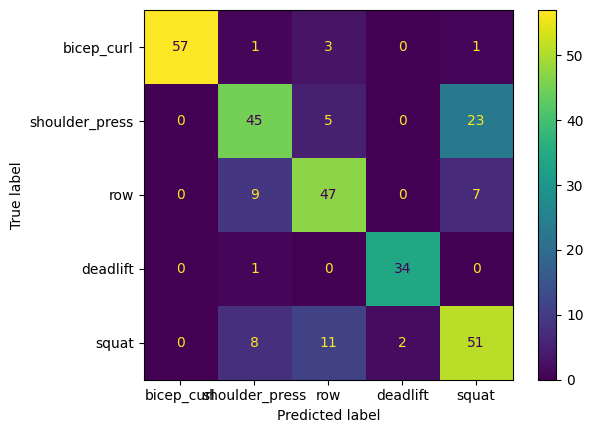

In [20]:
gru_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

# gru_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(gru_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()